### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [30]:
import HPO
import pysgpp
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.metrics
from sklearn.model_selection import KFold
import numpy as np
import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from numpy.random import seed
import random
import time
import os

random.seed(1)
seed(2)
tf.random.set_seed(3)

def reset_seeds():
    np.random.seed(1)
    random.seed(2)
    tf.random.set_seed(3)

VERBOSE = 1
CV = 2 #[(slice(None), slice(None))]
TESTING = True

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

### Hyperparameter space definition

In [31]:
hyperparameterspace = {
    'epochs': ["interval-int", 1, 20],
    #'batch_size': ["interval-int", 1, 200],
    'learning_rate': ["interval-log", 0.000000001, 0.1],
    #'number_layers': ["interval-int", 1, 20],
    #'neurons_per_layer': ["interval-int", 1, 50]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste



### Model definition

In [32]:

def create_model(learning_rate=0.0001, input_dim=10, number_layers=1, neurons_per_layer=20):
    # create model
    model = Sequential()

    model.add(Dense(neurons_per_layer, input_shape=(input_dim,), activation='relu'))
    for _ in range(number_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))
    model.add(Dense(1, activation=None))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


### Experiment parameters

In [33]:
DIRECTORY = "Current_tests/"+time.strftime("%H_%M_%S", time.localtime())

SPARSE_PARAMS = [2, 1, "gradient_descent"]

ITER = 12
BUDGETS = [2* x + 1 for x in range(ITER)]

for i in range(4):
    BUDGETS.append((i+1)**len(hyperparameterspace))

BUDGETS.sort()
BUDGETS = list(set(BUDGETS))



### Optimization

######################################################################################################################################################
Current Dataset: 1 of 5 with id: 233211
The average value for target is: tensor([3932.8892])
Min target: tensor([326.]) Max target: tensor([18823.])

################################################## Current Budget: 1 ##################################################

Performing grid search


2023-05-10 11:43:33.247259: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


With Hyperparameters: 
epochs: 10
learning_rate: 9.999999999999997e-06
Best score with Grid search: 0.6514994204044342

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.7557645291090012

Performing bayesian optimization
Iterations took 17.20486893100042 seconds
With Hyperparameters: 
epochs: 19.0
learning_rate: 0.00012816537271930948
Best score with Bayesian Optimization: 0.32813840359449387

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 9863ms.
########### Generated Grid: ###########


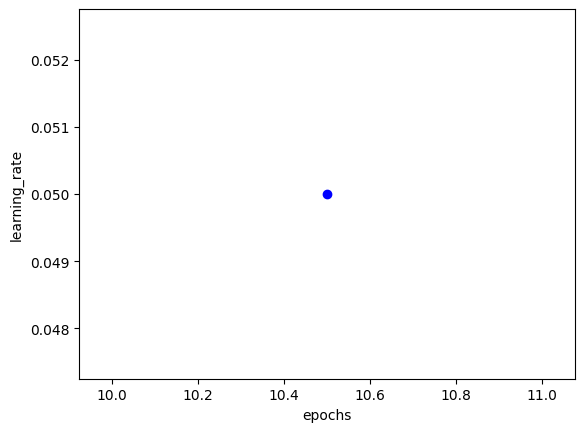

########### Interpreted Values: ###########


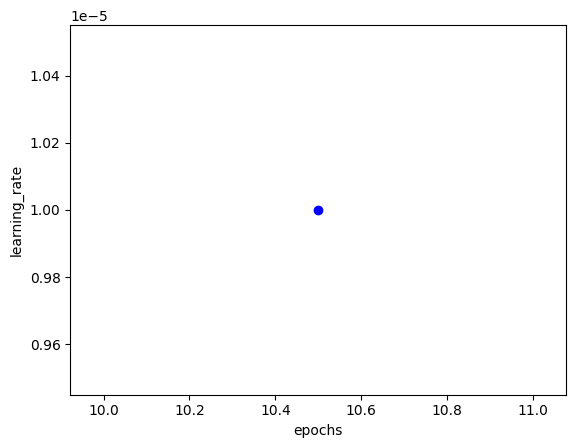

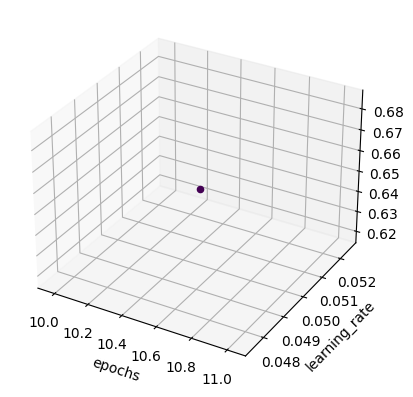

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 1e-05
Resulting loss:
0.6514994204044342
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 1e-05
Resulting loss (Optimal value from optimization):
0.6514994204044342
Resulting loss (Optimal point evaluated):
0.6514994204044342
Best score with Sparse Search: 0.6514994204044342 optimized: 0.6514994204044342
[0.6514994204044342]
[0.7557645291090012]
[0.32813840359449387]
[0.6514994204044342]
[0.6514994204044342]

################################################## Current Budget: 3 ##################################################

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.7557645291090012

Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 39.1943439150009 seconds
With Hyperparameters: 
epochs: 18.0
learning_rate: 1.551903216038066e-09
Best score with Bayesian Optimization: 0.6049282997846603
[0.6514994204044342]
[0.7557645291090012, 0.7557645291090012]
[0.32813840359449387, 0.6049282997846603]
[0.6514994204044342]
[0.6514994204044342]

################################################## Current Budget: 4 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 15
learning_rate: 0.0002154434690031884
Best score with Grid search: 0.27422036975622177

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.7557645291090012

Performing bayesian optimization
Iterations took 22.426281816001392 seconds
With Hyperparameters: 
epochs: 1.0
learning_rate: 5.237823945659564e-06
Best score with Bayesian Optimization: 1.0858286023139954
[0.6514994204044342, 0.27422036975622177]
[0.7557645291090012, 0.7

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 53.94540532799874 seconds
With Hyperparameters: 
epochs: 17.0
learning_rate: 0.0005139723919597603
Best score with Bayesian Optimization: 0.4081738069653511

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 50648ms.
########### Generated Grid: ###########


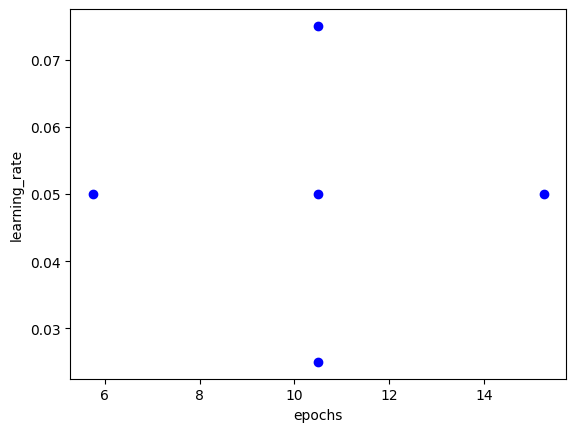

########### Interpreted Values: ###########


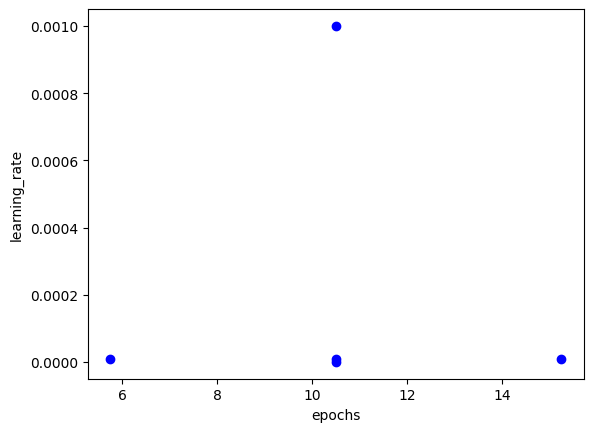

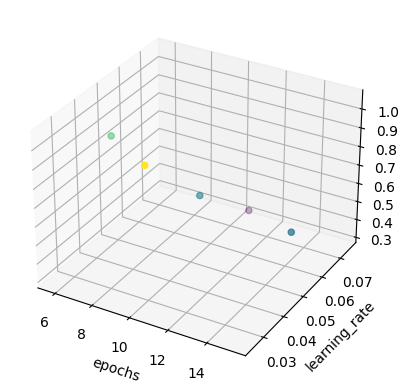

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.001
Resulting loss:
0.3235737234354019
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 0.1
Resulting loss (Optimal value from optimization):
-0.004351973533630371
Resulting loss (Optimal point evaluated):
0.7315517663955688
Best score with Sparse Search: 0.3235737234354019 optimized: 0.7315517663955688
[0.6514994204044342, 0.27422036975622177]
[0.7557645291090012, 0.7557645291090012, 0.7557645291090012, 0.26923079788684845]
[0.32813840359449387, 0.6049282997846603, 1.0858286023139954, 0.4081738069653511]
[0.6514994204044342, 0.3235737234354019]
[0.6514994204044342, 0.7315517663955688]

################################################## Current Budget: 7 ##################################################

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.0003032187151697306


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 90.25934394499927 seconds
With Hyperparameters: 
epochs: 16.360100818133052
learning_rate: 0.00031925075383867907
Best score with Bayesian Optimization: 0.28392693400382996
[0.6514994204044342, 0.27422036975622177]
[0.7557645291090012, 0.7557645291090012, 0.7557645291090012, 0.26923079788684845, 0.32885898649692535]
[0.32813840359449387, 0.6049282997846603, 1.0858286023139954, 0.4081738069653511, 0.28392693400382996]
[0.6514994204044342, 0.3235737234354019]
[0.6514994204044342, 0.7315517663955688]

################################################## Current Budget: 9 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 10
learning_rate: 0.0010000000000000002
Best score with Grid search: 0.3235737234354019

Performing random search
With Hyperparameters: 
epochs: 15
learning_rate: 0.00023106814689221575
Best score with Random search: 0.2845316752791405

Performing bayesian optimization
Iterations took 126.69175416599865 

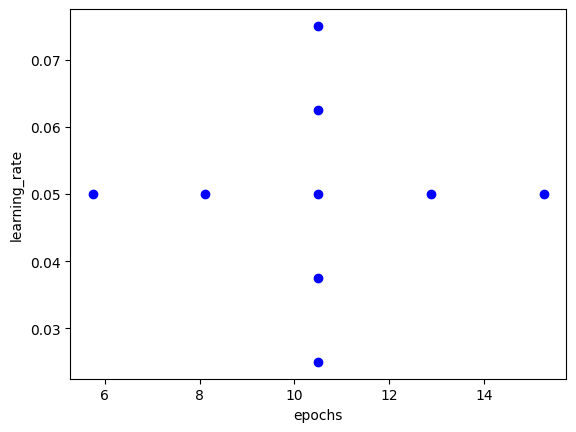

########### Interpreted Values: ###########


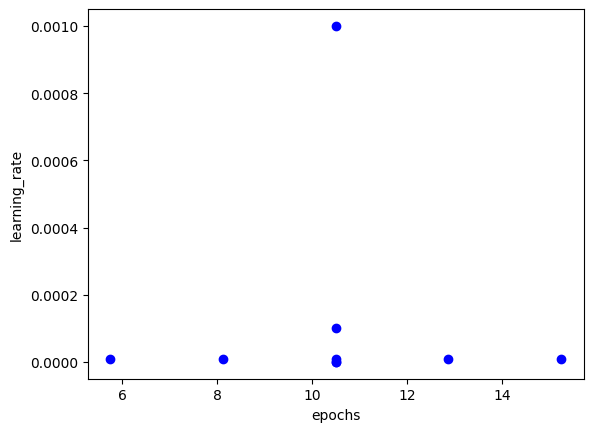

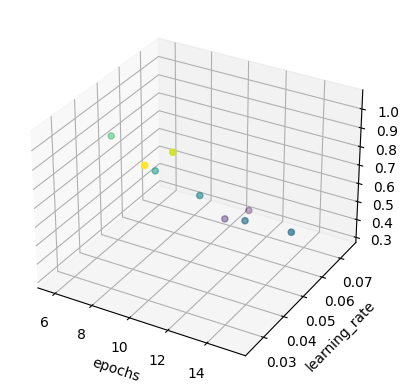

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.001
Resulting loss:
0.3235737234354019
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 19.99999555799271
learning_rate: 0.09999954757945656
Resulting loss (Optimal value from optimization):
-0.11116038305477638
Resulting loss (Optimal point evaluated):
0.7701140940189362
Best score with Sparse Search: 0.3235737234354019 optimized: 0.7701140940189362
[0.6514994204044342, 0.27422036975622177, 0.3235737234354019]
[0.7557645291090012, 0.7557645291090012, 0.7557645291090012, 0.26923079788684845, 0.32885898649692535, 0.2845316752791405]
[0.32813840359449387, 0.6049282997846603, 1.0858286023139954, 0.4081738069653511, 0.28392693400382996, 0.3406590446829796]
[0.6514994204044342, 0.3235737234354019, 0.3235737234354019]
[0.6514994204044342, 0.7315517663955688, 0.7701140940189362]

##############################################

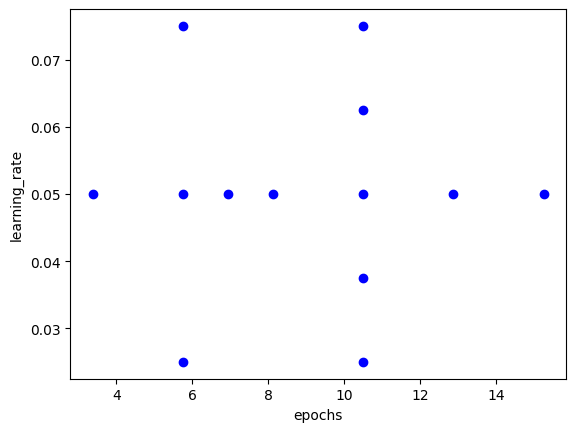

########### Interpreted Values: ###########


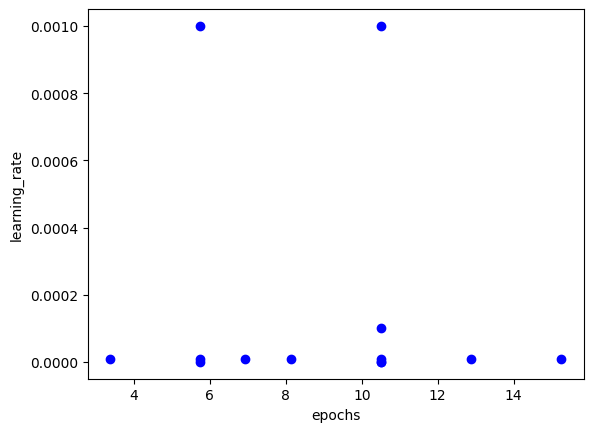

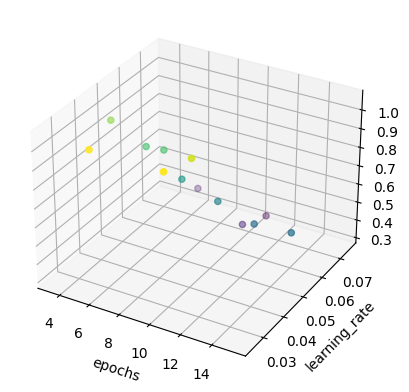

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.001
Resulting loss:
0.3235737234354019
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 19.99999555799271
learning_rate: 0.09999954757945656
Resulting loss (Optimal value from optimization):
-0.11116038305477638
Resulting loss (Optimal point evaluated):
0.7701140940189362
Best score with Sparse Search: 0.3235737234354019 optimized: 0.7701140940189362
[0.6514994204044342, 0.27422036975622177, 0.3235737234354019]
[0.7557645291090012, 0.7557645291090012, 0.7557645291090012, 0.26923079788684845, 0.32885898649692535, 0.2845316752791405, 0.2845316752791405, 0.453013151884079]
[0.32813840359449387, 0.6049282997846603, 1.0858286023139954, 0.4081738069653511, 0.28392693400382996, 0.3406590446829796, 0.47055354714393616, 0.34305034577846527]
[0.6514994204044342, 0.3235737234354019, 0.3235737234354019, 0.3235737234354019]
[0.6514

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 158.21107569400192 seconds
With Hyperparameters: 
epochs: 15.795009969053083
learning_rate: 0.0002536413953238734
Best score with Bayesian Optimization: 0.29488517343997955
[0.6514994204044342, 0.27422036975622177, 0.3235737234354019, 0.3897950276732445]
[0.7557645291090012, 0.7557645291090012, 0.7557645291090012, 0.26923079788684845, 0.32885898649692535, 0.2845316752791405, 0.2845316752791405, 0.453013151884079, 0.2845316752791405, 0.2845316752791405]
[0.32813840359449387, 0.6049282997846603, 1.0858286023139954, 0.4081738069653511, 0.28392693400382996, 0.3406590446829796, 0.47055354714393616, 0.34305034577846527, 0.2818319946527481, 0.29488517343997955]
[0.6514994204044342, 0.3235737234354019, 0.3235737234354019, 0.3235737234354019]
[0.6514994204044342, 0.7315517663955688, 0.7701140940189362, 0.7701140940189362]

################################################## Current Budget: 17 ##################################################

Performing random search
With Hyperp

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 193.2453059840027 seconds
With Hyperparameters: 
epochs: 12.739926211994485
learning_rate: 0.0001743411422205021
Best score with Bayesian Optimization: 0.27747872471809387

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 157143ms.
########### Generated Grid: ###########


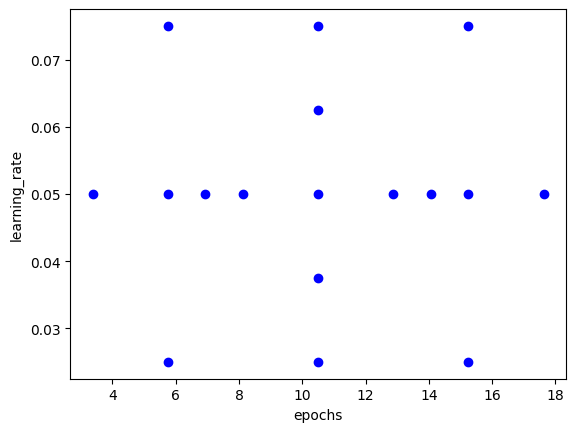

########### Interpreted Values: ###########


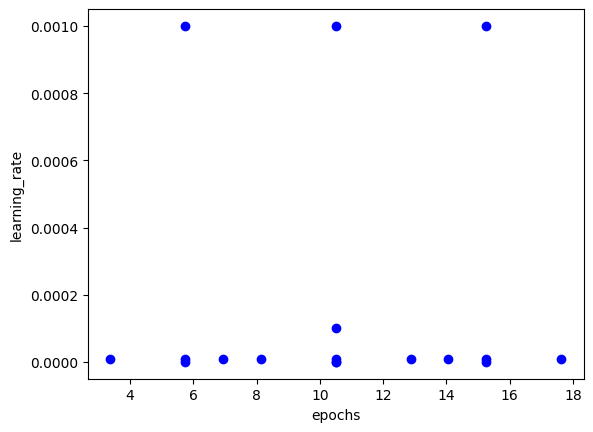

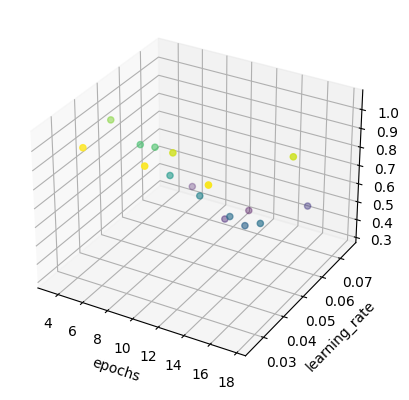

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.001
Resulting loss:
0.3235737234354019
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 1.000007601267612
learning_rate: 0.09999851647932691
Resulting loss (Optimal value from optimization):
-0.20560862136285873
Resulting loss (Optimal point evaluated):
2.8726136684417725
Best score with Sparse Search: 0.3235737234354019 optimized: 2.8726136684417725
[0.6514994204044342, 0.27422036975622177, 0.3235737234354019, 0.3897950276732445]
[0.7557645291090012, 0.7557645291090012, 0.7557645291090012, 0.26923079788684845, 0.32885898649692535, 0.2845316752791405, 0.2845316752791405, 0.453013151884079, 0.2845316752791405, 0.2845316752791405, 0.2947501763701439]
[0.32813840359449387, 0.6049282997846603, 1.0858286023139954, 0.4081738069653511, 0.28392693400382996, 0.3406590446829796, 0.47055354714393616, 0.34305034577846527, 0.281831

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 174.45460778300185 seconds
With Hyperparameters: 
epochs: 7.4059844461783335
learning_rate: 0.0007651620803102773
Best score with Bayesian Optimization: 0.27826526015996933

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 194810ms.
########### Generated Grid: ###########


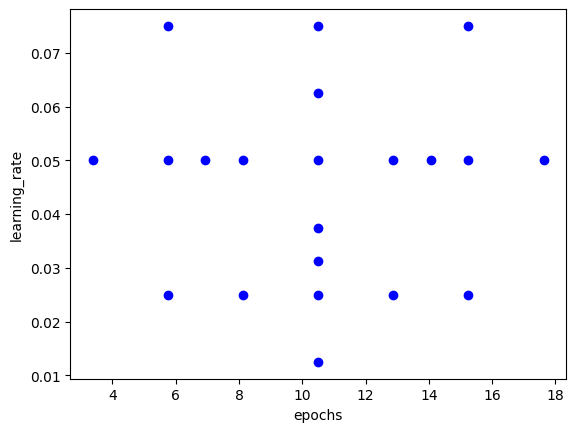

########### Interpreted Values: ###########


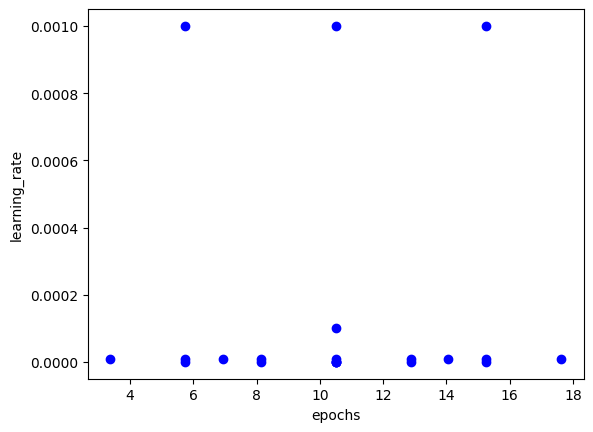

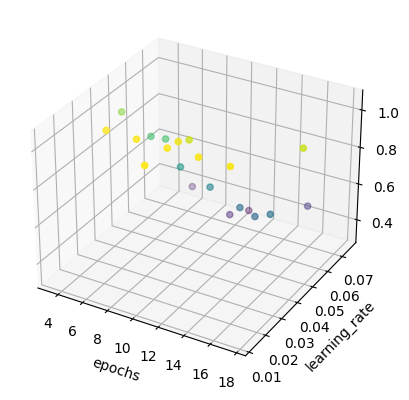

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.001
Resulting loss:
0.3235737234354019
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 1.000007601267612
learning_rate: 0.09999851647932691
Resulting loss (Optimal value from optimization):
-0.20560862136285873
Resulting loss (Optimal point evaluated):
2.8726136684417725
Best score with Sparse Search: 0.3235737234354019 optimized: 2.8726136684417725
[0.6514994204044342, 0.27422036975622177, 0.3235737234354019, 0.3897950276732445]
[0.7557645291090012, 0.7557645291090012, 0.7557645291090012, 0.26923079788684845, 0.32885898649692535, 0.2845316752791405, 0.2845316752791405, 0.453013151884079, 0.2845316752791405, 0.2845316752791405, 0.2947501763701439, 0.2845316752791405, 0.36214373260736465]
[0.32813840359449387, 0.6049282997846603, 1.0858286023139954, 0.4081738069653511, 0.28392693400382996, 0.3406590446829796, 0.4705535

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 186.10235509000267 seconds
With Hyperparameters: 
epochs: 9.0
learning_rate: 0.0007079129771491852
Best score with Bayesian Optimization: 0.3167181462049484
[0.6514994204044342, 0.27422036975622177, 0.3235737234354019, 0.3897950276732445]
[0.7557645291090012, 0.7557645291090012, 0.7557645291090012, 0.26923079788684845, 0.32885898649692535, 0.2845316752791405, 0.2845316752791405, 0.453013151884079, 0.2845316752791405, 0.2845316752791405, 0.2947501763701439, 0.2845316752791405, 0.36214373260736465, 0.2802940681576729]
[0.32813840359449387, 0.6049282997846603, 1.0858286023139954, 0.4081738069653511, 0.28392693400382996, 0.3406590446829796, 0.47055354714393616, 0.34305034577846527, 0.2818319946527481, 0.29488517343997955, 0.27747872471809387, 0.2521718069911003, 0.27826526015996933, 0.3167181462049484]
[0.6514994204044342, 0.3235737234354019, 0.3235737234354019, 0.3235737234354019, 0.3235737234354019, 0.3235737234354019]
[0.6514994204044342, 0.7315517663955688, 0.7701140940

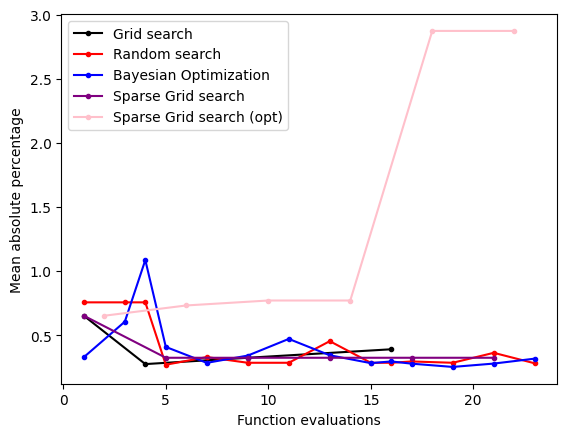

######################################################################################################################################################
Current Dataset: 2 of 5 with id: 359952
The average value for target is: tensor([50076.3906])
Min target: tensor([0.]) Max target: tensor([500001.])

################################################## Current Budget: 1 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 10
learning_rate: 9.999999999999997e-06
Best score with Grid search: 0.9117116630077362

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.5268127769231796

Performing bayesian optimization
Iterations took 6.982940032001352 seconds
With Hyperparameters: 
epochs: 9.0
learning_rate: 0.002962759211873722
Best score with Bayesian Optimization: 0.47024206817150116

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 4580ms.
#

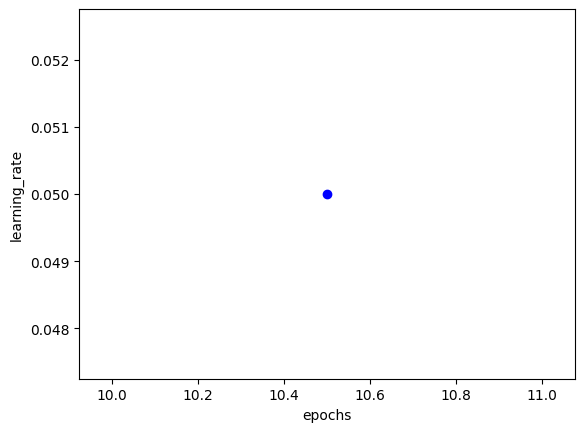

########### Interpreted Values: ###########


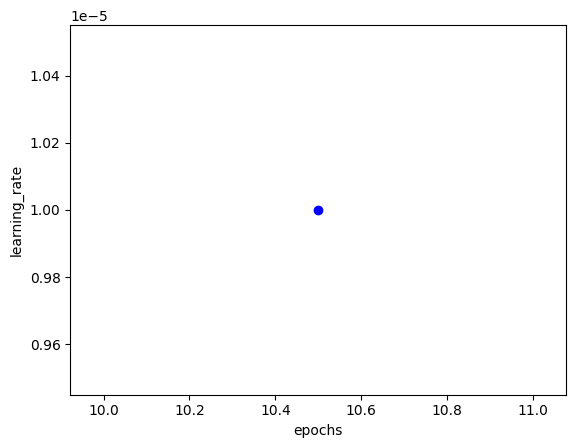

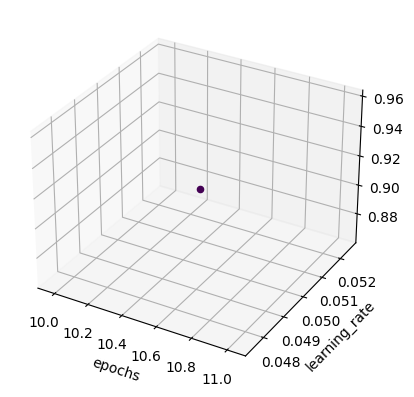


Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 1e-05
Resulting loss:
0.9117116630077362
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 1e-05
Resulting loss (Optimal value from optimization):
0.9117116630077362
Resulting loss (Optimal point evaluated):
0.9117116630077362
Best score with Sparse Search: 0.9117116630077362 optimized: 0.9117116630077362
[0.9117116630077362]
[0.5268127769231796]
[0.47024206817150116]
[0.9117116630077362]
[0.9117116630077362]

################################################## Current Budget: 3 ##################################################

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.5268127769231796

Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 17.47218345699912 seconds
With Hyperparameters: 
epochs: 18.0
learning_rate: 1.551903216038066e-09
Best score with Bayesian Optimization: 0.6147802174091339
[0.9117116630077362]
[0.5268127769231796, 0.5268127769231796]
[0.47024206817150116, 0.6147802174091339]
[0.9117116630077362]
[0.9117116630077362]

################################################## Current Budget: 4 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 5
learning_rate: 4.6415888336127847e-07
Best score with Grid search: 0.8284070789813995

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.5268127769231796

Performing bayesian optimization
Iterations took 15.234825731000456 seconds
With Hyperparameters: 
epochs: 18.0
learning_rate: 1.0814103849756585e-05
Best score with Bayesian Optimization: 0.6648495495319366
[0.9117116630077362, 0.8284070789813995]
[0.5268127769231796, 0.

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 22.199083102999793 seconds
With Hyperparameters: 
epochs: 1.0
learning_rate: 1.9418384414235233e-07
Best score with Bayesian Optimization: 0.720125138759613

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 22533ms.
########### Generated Grid: ###########


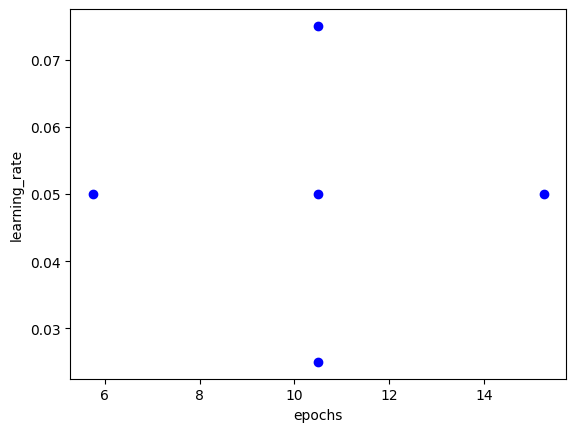

########### Interpreted Values: ###########


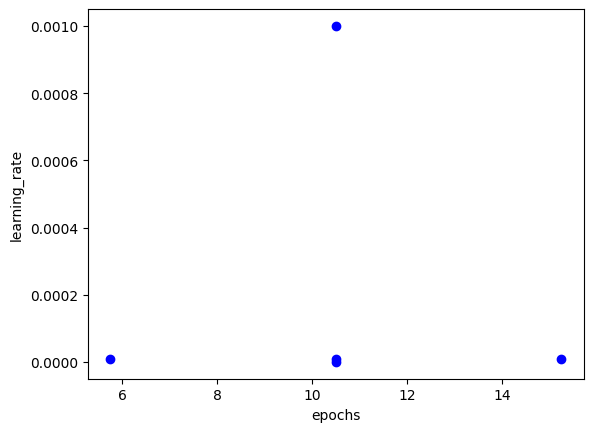

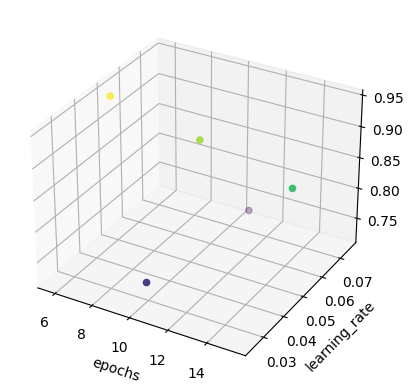

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.001
Resulting loss:
0.7247560024261475
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 0.1
Resulting loss (Optimal value from optimization):
0.5378003418445587
Resulting loss (Optimal point evaluated):
0.7052212953567505
Best score with Sparse Search: 0.7247560024261475 optimized: 0.7052212953567505
[0.9117116630077362, 0.8284070789813995]
[0.5268127769231796, 0.5268127769231796, 0.5268127769231796, 0.5510313808917999]
[0.47024206817150116, 0.6147802174091339, 0.6648495495319366, 0.720125138759613]
[0.9117116630077362, 0.7247560024261475]
[0.9117116630077362, 0.7052212953567505]

################################################## Current Budget: 7 ##################################################

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best sco

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 39.74610205699537 seconds
With Hyperparameters: 
epochs: 18.337258687354833
learning_rate: 0.013869636169435174
Best score with Bayesian Optimization: 0.35247592628002167
[0.9117116630077362, 0.8284070789813995]
[0.5268127769231796, 0.5268127769231796, 0.5268127769231796, 0.5510313808917999, 0.5268127769231796]
[0.47024206817150116, 0.6147802174091339, 0.6648495495319366, 0.720125138759613, 0.35247592628002167]
[0.9117116630077362, 0.7247560024261475]
[0.9117116630077362, 0.7052212953567505]

################################################## Current Budget: 9 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 16
learning_rate: 0.0010000000000000002
Best score with Grid search: 0.6994580924510956

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.5268127769231796

Performing bayesian optimization
Iterations took 53.467091195998364 seconds
Wi

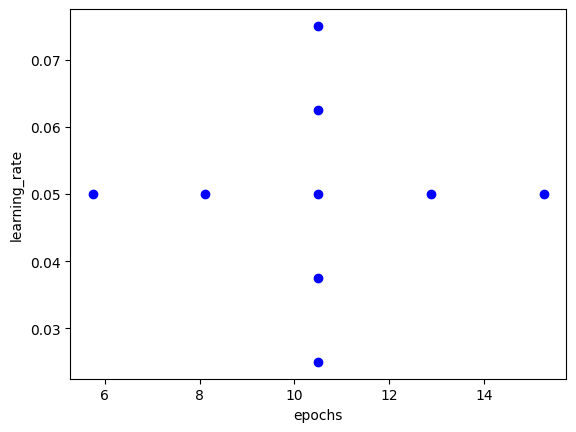

########### Interpreted Values: ###########


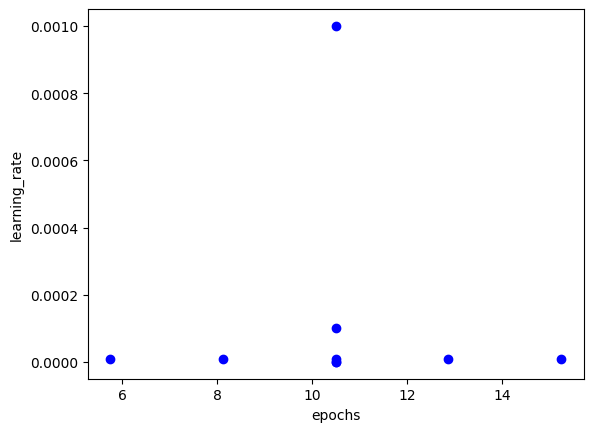

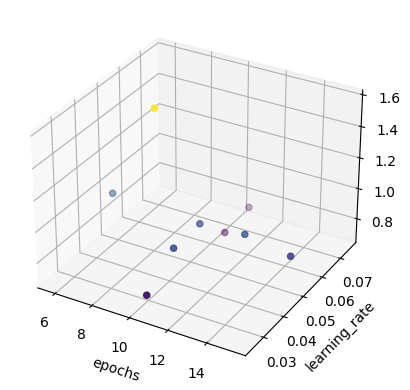

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.0001
Resulting loss:
0.7034635841846466
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 0.0001
Resulting loss (Optimal value from optimization):
0.7034635841846466
Resulting loss (Optimal point evaluated):
0.7034635841846466
Best score with Sparse Search: 0.7034635841846466 optimized: 0.7034635841846466
[0.9117116630077362, 0.8284070789813995, 0.6994580924510956]
[0.5268127769231796, 0.5268127769231796, 0.5268127769231796, 0.5510313808917999, 0.5268127769231796, 0.5268127769231796]
[0.47024206817150116, 0.6147802174091339, 0.6648495495319366, 0.720125138759613, 0.35247592628002167, 0.36425264179706573]
[0.9117116630077362, 0.7247560024261475, 0.7034635841846466]
[0.9117116630077362, 0.7052212953567505, 0.7034635841846466]

################################################## Current Budget: 11 ######

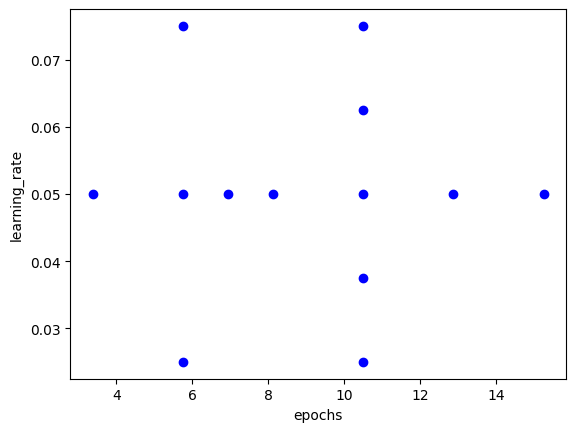

########### Interpreted Values: ###########


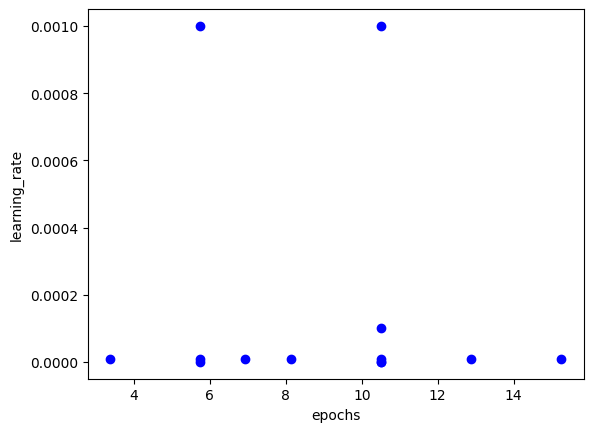

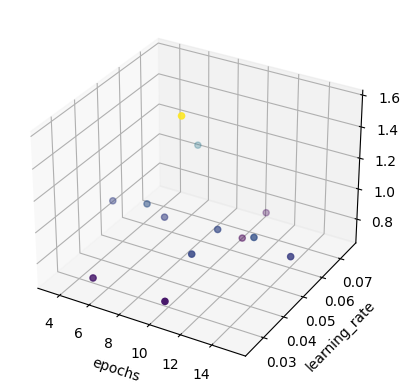

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.0001
Resulting loss:
0.7034635841846466
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 0.0001
Resulting loss (Optimal value from optimization):
0.7034635841846466
Resulting loss (Optimal point evaluated):
0.7034635841846466
Best score with Sparse Search: 0.7034635841846466 optimized: 0.7034635841846466
[0.9117116630077362, 0.8284070789813995, 0.6994580924510956]
[0.5268127769231796, 0.5268127769231796, 0.5268127769231796, 0.5510313808917999, 0.5268127769231796, 0.5268127769231796, 0.5268127769231796, 0.36328159272670746]
[0.47024206817150116, 0.6147802174091339, 0.6648495495319366, 0.720125138759613, 0.35247592628002167, 0.36425264179706573, 0.4601706266403198, 0.44731076061725616]
[0.9117116630077362, 0.7247560024261475, 0.7034635841846466, 0.7034635841846466]
[0.9117116630077362, 0.7052212953567

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 70.00004250799975 seconds
With Hyperparameters: 
epochs: 9.0
learning_rate: 0.009956445728250536
Best score with Bayesian Optimization: 0.3844423294067383
[0.9117116630077362, 0.8284070789813995, 0.6994580924510956, 0.48142969608306885]
[0.5268127769231796, 0.5268127769231796, 0.5268127769231796, 0.5510313808917999, 0.5268127769231796, 0.5268127769231796, 0.5268127769231796, 0.36328159272670746, 0.5034296661615372, 0.39925195276737213]
[0.47024206817150116, 0.6147802174091339, 0.6648495495319366, 0.720125138759613, 0.35247592628002167, 0.36425264179706573, 0.4601706266403198, 0.44731076061725616, 0.4009747952222824, 0.3844423294067383]
[0.9117116630077362, 0.7247560024261475, 0.7034635841846466, 0.7034635841846466]
[0.9117116630077362, 0.7052212953567505, 0.7034635841846466, 0.7034635841846466]

################################################## Current Budget: 17 ##################################################

Performing random search
With Hyperparameters: 
epochs:

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 65.59335195899621 seconds
With Hyperparameters: 
epochs: 1.0
learning_rate: 0.025088687341056074
Best score with Bayesian Optimization: 0.4893835783004761

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 76903ms.
########### Generated Grid: ###########


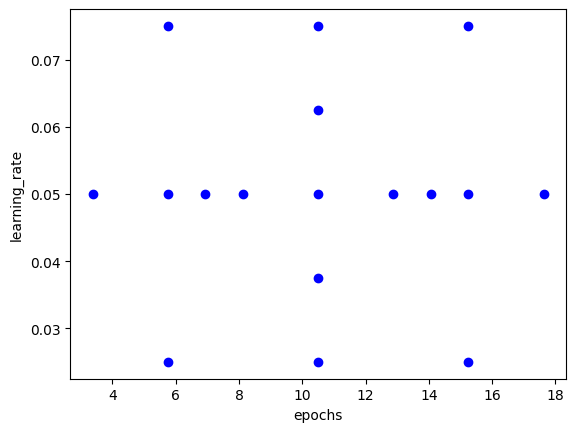

########### Interpreted Values: ###########


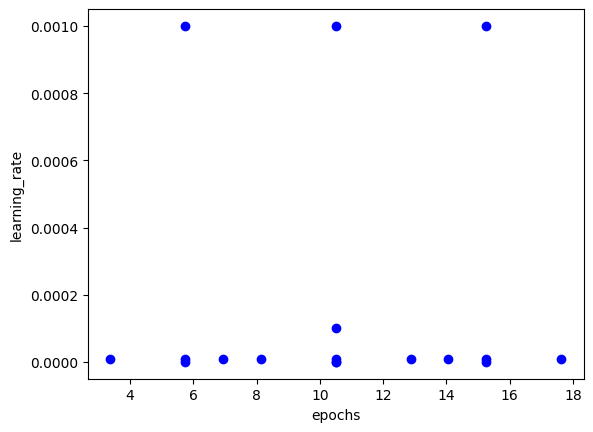

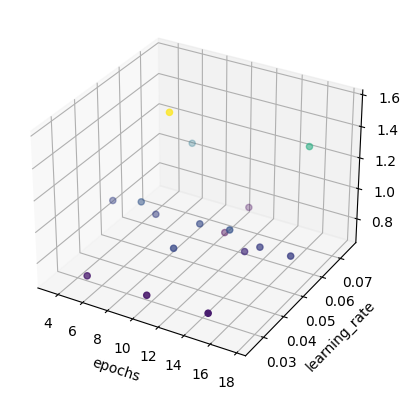

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.0001
Resulting loss:
0.7034635841846466
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 0.0001
Resulting loss (Optimal value from optimization):
0.7034635841846466
Resulting loss (Optimal point evaluated):
0.7034635841846466
Best score with Sparse Search: 0.7034635841846466 optimized: 0.7034635841846466
[0.9117116630077362, 0.8284070789813995, 0.6994580924510956, 0.48142969608306885]
[0.5268127769231796, 0.5268127769231796, 0.5268127769231796, 0.5510313808917999, 0.5268127769231796, 0.5268127769231796, 0.5268127769231796, 0.36328159272670746, 0.5034296661615372, 0.39925195276737213, 0.44040901958942413]
[0.47024206817150116, 0.6147802174091339, 0.6648495495319366, 0.720125138759613, 0.35247592628002167, 0.36425264179706573, 0.4601706266403198, 0.44731076061725616, 0.4009747952222824, 0.384442329406

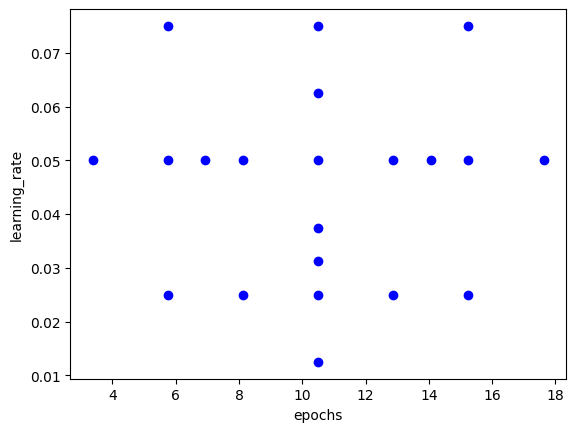

########### Interpreted Values: ###########


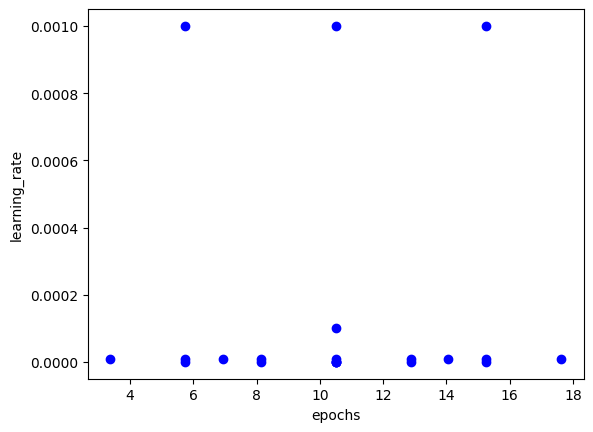

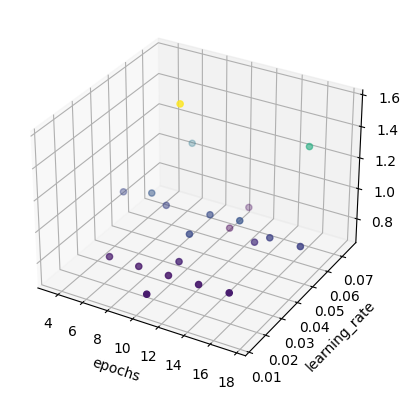

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.0001
Resulting loss:
0.7034635841846466
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 0.0001
Resulting loss (Optimal value from optimization):
0.7034635841846466
Resulting loss (Optimal point evaluated):
0.7034635841846466
Best score with Sparse Search: 0.7034635841846466 optimized: 0.7034635841846466
[0.9117116630077362, 0.8284070789813995, 0.6994580924510956, 0.48142969608306885]
[0.5268127769231796, 0.5268127769231796, 0.5268127769231796, 0.5510313808917999, 0.5268127769231796, 0.5268127769231796, 0.5268127769231796, 0.36328159272670746, 0.5034296661615372, 0.39925195276737213, 0.44040901958942413, 0.39925195276737213, 0.3721691220998764]
[0.47024206817150116, 0.6147802174091339, 0.6648495495319366, 0.720125138759613, 0.35247592628002167, 0.36425264179706573, 0.4601706266403198, 0.447310760617

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 108.7638948749991 seconds
With Hyperparameters: 
epochs: 6.883784732605875
learning_rate: 0.005414798386695557
Best score with Bayesian Optimization: 0.45516470074653625
[0.9117116630077362, 0.8284070789813995, 0.6994580924510956, 0.48142969608306885]
[0.5268127769231796, 0.5268127769231796, 0.5268127769231796, 0.5510313808917999, 0.5268127769231796, 0.5268127769231796, 0.5268127769231796, 0.36328159272670746, 0.5034296661615372, 0.39925195276737213, 0.44040901958942413, 0.39925195276737213, 0.3721691220998764, 0.39925195276737213]
[0.47024206817150116, 0.6147802174091339, 0.6648495495319366, 0.720125138759613, 0.35247592628002167, 0.36425264179706573, 0.4601706266403198, 0.44731076061725616, 0.4009747952222824, 0.3844423294067383, 0.4893835783004761, 0.35055698454380035, 0.4165533185005188, 0.45516470074653625]
[0.9117116630077362, 0.7247560024261475, 0.7034635841846466, 0.7034635841846466, 0.7034635841846466, 0.7034635841846466]
[0.9117116630077362, 0.7052212953567505

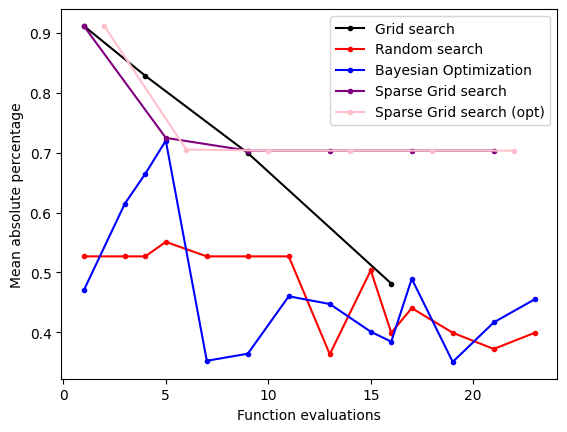

######################################################################################################################################################
Current Dataset: 3 of 5 with id: 359931
The average value for target is: tensor([15.0746])
Min target: tensor([12.5000]) Max target: tensor([17.5000])

################################################## Current Budget: 1 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 10
learning_rate: 9.999999999999997e-06
Best score with Grid search: 0.044642310589551926

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.045808492228388786

Performing bayesian optimization
Iterations took 1.357511408999926 seconds
With Hyperparameters: 
epochs: 19.0
learning_rate: 0.00012816537271930948
Best score with Bayesian Optimization: 0.04612944647669792

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 

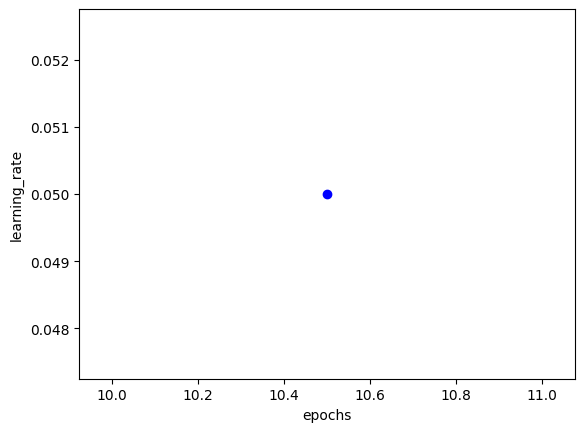

########### Interpreted Values: ###########


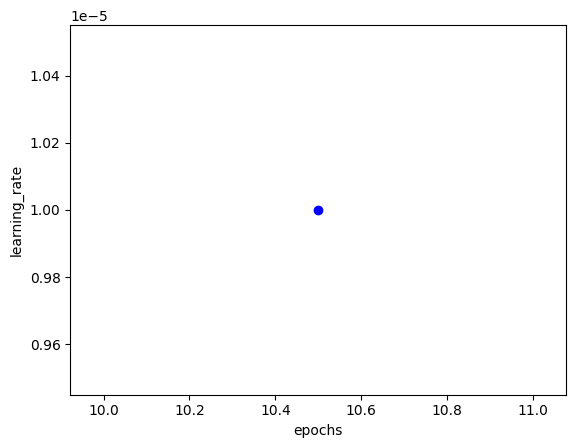

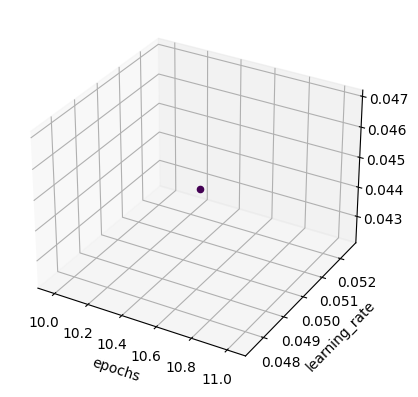

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 1e-05
Resulting loss:
0.044642310589551926
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 1e-05
Resulting loss (Optimal value from optimization):
0.044642310589551926
Resulting loss (Optimal point evaluated):
0.044642310589551926
Best score with Sparse Search: 0.044642310589551926 optimized: 0.044642310589551926
[0.044642310589551926]
[0.045808492228388786]
[0.04612944647669792]
[0.044642310589551926]
[0.044642310589551926]

################################################## Current Budget: 3 ##################################################

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.045808492228388786

Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 4.004469205998248 seconds
With Hyperparameters: 
epochs: 15.205036481725303
learning_rate: 1e-09
Best score with Bayesian Optimization: 0.04599708877503872
[0.044642310589551926]
[0.045808492228388786, 0.045808492228388786]
[0.04612944647669792, 0.04599708877503872]
[0.044642310589551926]
[0.044642310589551926]

################################################## Current Budget: 4 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 5
learning_rate: 4.6415888336127847e-07
Best score with Grid search: 0.04462846741080284

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.045808492228388786

Performing bayesian optimization
Iterations took 4.703726680998443 seconds
With Hyperparameters: 
epochs: 1.0
learning_rate: 5.237823945659564e-06
Best score with Bayesian Optimization: 0.04439791664481163
[0.044642310589551926, 0.04462846741080284]
[0.045808

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 7.092559591999816 seconds
With Hyperparameters: 
epochs: 18.999999893032623
learning_rate: 8.130264523104982e-06
Best score with Bayesian Optimization: 0.043298400938510895

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 5825ms.
########### Generated Grid: ###########


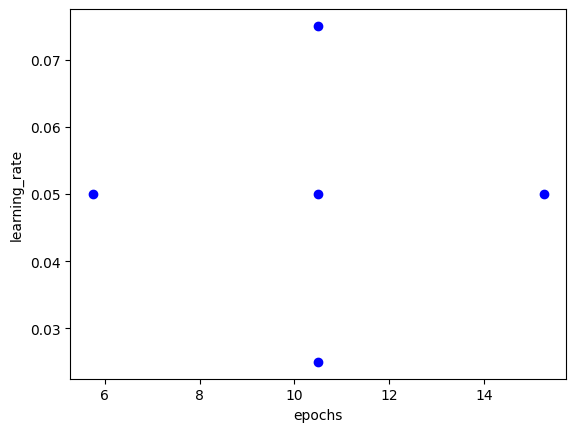

########### Interpreted Values: ###########


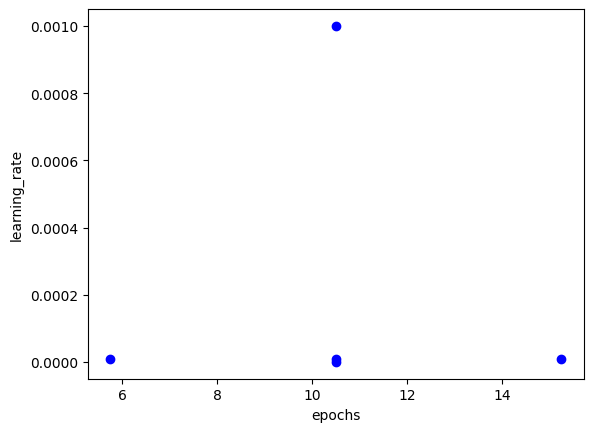

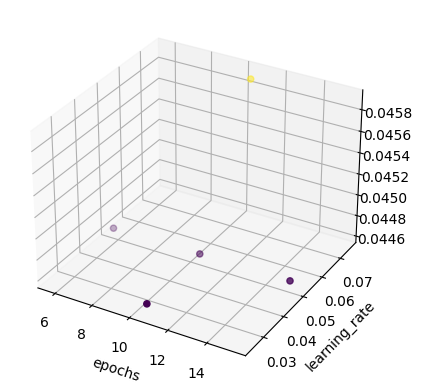

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 1.0000000000000001e-07
Resulting loss:
0.04462821967899799
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 1e-09
Resulting loss (Optimal value from optimization):
0.04461412876844406
Resulting loss (Optimal point evaluated):
0.04462807811796665
Best score with Sparse Search: 0.04462821967899799 optimized: 0.04462807811796665
[0.044642310589551926, 0.04462846741080284]
[0.045808492228388786, 0.045808492228388786, 0.045808492228388786, 0.04279155656695366]
[0.04612944647669792, 0.04599708877503872, 0.04439791664481163, 0.043298400938510895]
[0.044642310589551926, 0.04462821967899799]
[0.044642310589551926, 0.04462807811796665]

################################################## Current Budget: 7 ##################################################

Performing random search
With Hyperparameters: 
epochs: 

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 9.381600347998756 seconds
With Hyperparameters: 
epochs: 6.0
learning_rate: 4.828714291748029e-08
Best score with Bayesian Optimization: 0.04387652687728405
[0.044642310589551926, 0.04462846741080284]
[0.045808492228388786, 0.045808492228388786, 0.045808492228388786, 0.04279155656695366, 0.04475080966949463]
[0.04612944647669792, 0.04599708877503872, 0.04439791664481163, 0.043298400938510895, 0.04387652687728405]
[0.044642310589551926, 0.04462821967899799]
[0.044642310589551926, 0.04462807811796665]

################################################## Current Budget: 9 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 4
learning_rate: 9.999999999999994e-08
Best score with Grid search: 0.04462814889848232

Performing random search
With Hyperparameters: 
epochs: 15
learning_rate: 0.00023106814689221575
Best score with Random search: 0.04409589618444443

Performing bayesian optimization
Iterations took 11.7231897240017

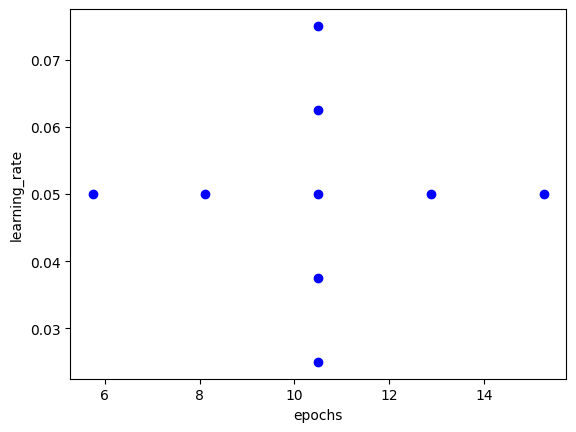

########### Interpreted Values: ###########


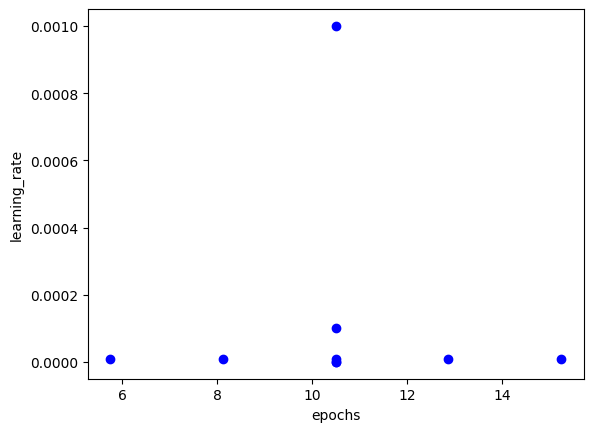

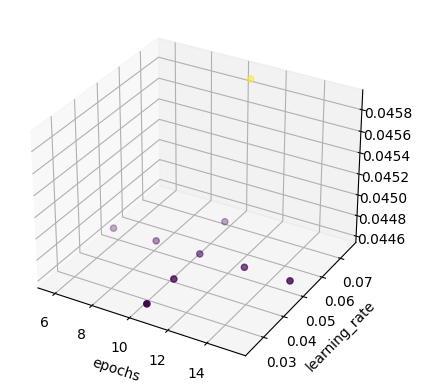

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 1.0000000000000001e-07
Resulting loss:
0.04462821967899799
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 12.07855515235976
learning_rate: 1.0001984156374487e-09
Resulting loss (Optimal value from optimization):
0.04461556176005589
Resulting loss (Optimal point evaluated):
0.04462807811796665
Best score with Sparse Search: 0.04462821967899799 optimized: 0.04462807811796665
[0.044642310589551926, 0.04462846741080284, 0.04462814889848232]
[0.045808492228388786, 0.045808492228388786, 0.045808492228388786, 0.04279155656695366, 0.04475080966949463, 0.04409589618444443]
[0.04612944647669792, 0.04599708877503872, 0.04439791664481163, 0.043298400938510895, 0.04387652687728405, 0.043619729578495026]
[0.044642310589551926, 0.04462821967899799, 0.04462821967899799]
[0.044642310589551926, 0.04462807811796665, 0.04462807811796665]


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 13.737435439001274 seconds
With Hyperparameters: 
epochs: 18.0
learning_rate: 1.9474989241646192e-08
Best score with Bayesian Optimization: 0.042886245995759964
[0.044642310589551926, 0.04462846741080284, 0.04462814889848232]
[0.045808492228388786, 0.045808492228388786, 0.045808492228388786, 0.04279155656695366, 0.04475080966949463, 0.04409589618444443, 0.04297270067036152]
[0.04612944647669792, 0.04599708877503872, 0.04439791664481163, 0.043298400938510895, 0.04387652687728405, 0.043619729578495026, 0.042886245995759964]
[0.044642310589551926, 0.04462821967899799, 0.04462821967899799]
[0.044642310589551926, 0.04462807811796665, 0.04462807811796665]

################################################## Current Budget: 13 ##################################################

Performing random search
With Hyperparameters: 
epochs: 3
learning_rate: 0.05318809423217144
Best score with Random search: 0.04322551563382149

Performing bayesian optimization
Iterations took 16.481210

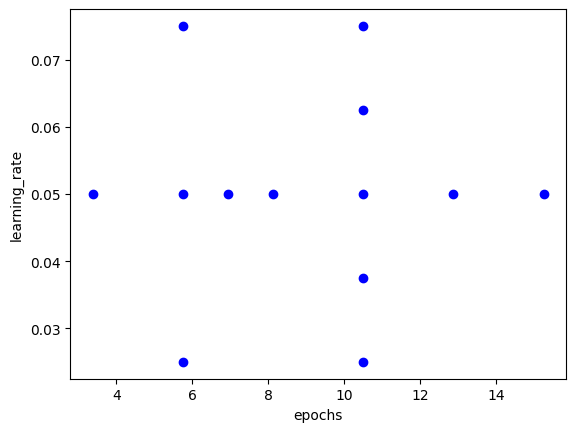

########### Interpreted Values: ###########


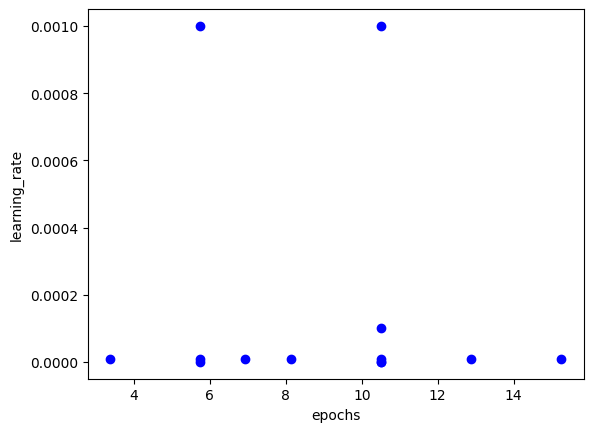

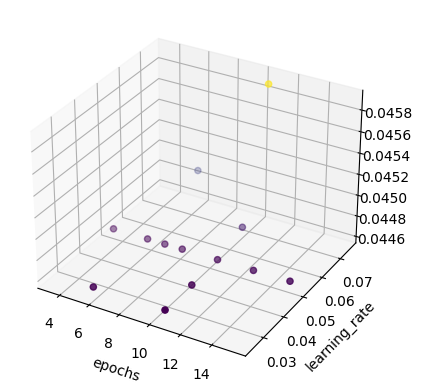

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 5.75
learning_rate: 1.0000000000000001e-07
Resulting loss:
0.04462815821170807
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 1.0000107359949972
learning_rate: 0.09999922070457026
Resulting loss (Optimal value from optimization):
0.04312196210120897
Resulting loss (Optimal point evaluated):
0.05238778702914715
Best score with Sparse Search: 0.04462815821170807 optimized: 0.05238778702914715
[0.044642310589551926, 0.04462846741080284, 0.04462814889848232]
[0.045808492228388786, 0.045808492228388786, 0.045808492228388786, 0.04279155656695366, 0.04475080966949463, 0.04409589618444443, 0.04297270067036152, 0.04322551563382149]
[0.04612944647669792, 0.04599708877503872, 0.04439791664481163, 0.043298400938510895, 0.04387652687728405, 0.043619729578495026, 0.042886245995759964, 0.04308774322271347]
[0.044642310589551926, 0.04462821967899799, 0.0

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 18.74910802500017 seconds
With Hyperparameters: 
epochs: 3.0
learning_rate: 6.05670047460482e-06
Best score with Bayesian Optimization: 0.043307915329933167
[0.044642310589551926, 0.04462846741080284, 0.04462814889848232]
[0.045808492228388786, 0.045808492228388786, 0.045808492228388786, 0.04279155656695366, 0.04475080966949463, 0.04409589618444443, 0.04297270067036152, 0.04322551563382149, 0.04297270067036152]
[0.04612944647669792, 0.04599708877503872, 0.04439791664481163, 0.043298400938510895, 0.04387652687728405, 0.043619729578495026, 0.042886245995759964, 0.04308774322271347, 0.043307915329933167]
[0.044642310589551926, 0.04462821967899799, 0.04462821967899799, 0.04462815821170807]
[0.044642310589551926, 0.04462807811796665, 0.04462807811796665, 0.05238778702914715]

################################################## Current Budget: 16 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 3
learning_rate: 3.9810717

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 21.02749215500262 seconds
With Hyperparameters: 
epochs: 5.0
learning_rate: 0.05704219114617561
Best score with Bayesian Optimization: 0.04298211820423603

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 20237ms.
########### Generated Grid: ###########


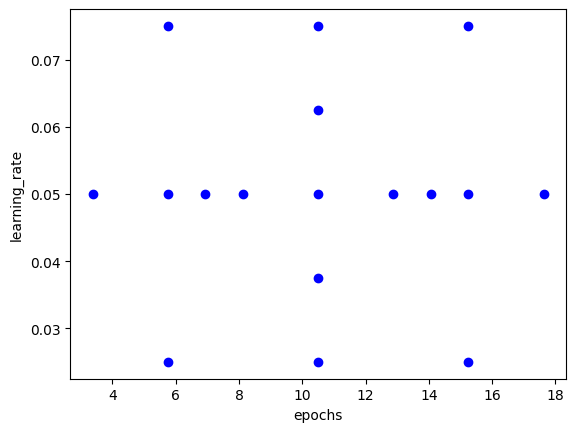

########### Interpreted Values: ###########


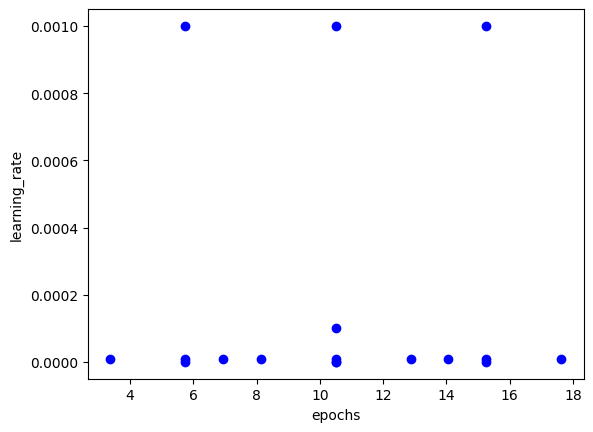

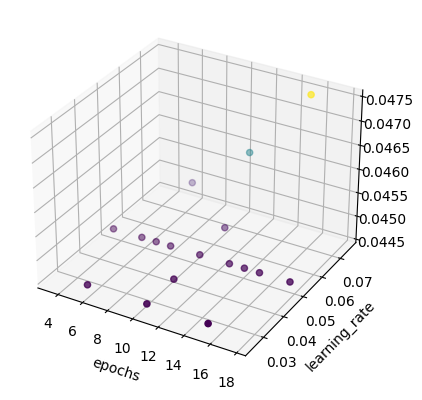

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 5.75
learning_rate: 1.0000000000000001e-07
Resulting loss:
0.04462815821170807
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 1.0000107359949972
learning_rate: 0.09999922070457026
Resulting loss (Optimal value from optimization):
0.04312196210120897
Resulting loss (Optimal point evaluated):
0.05238778702914715
Best score with Sparse Search: 0.04462815821170807 optimized: 0.05238778702914715
[0.044642310589551926, 0.04462846741080284, 0.04462814889848232, 0.04462809860706329]
[0.045808492228388786, 0.045808492228388786, 0.045808492228388786, 0.04279155656695366, 0.04475080966949463, 0.04409589618444443, 0.04297270067036152, 0.04322551563382149, 0.04297270067036152, 0.04297270067036152, 0.04294790141284466]
[0.04612944647669792, 0.04599708877503872, 0.04439791664481163, 0.043298400938510895, 0.04387652687728405, 0.043619729578495026, 0.0428

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 23.586341722002544 seconds
With Hyperparameters: 
epochs: 2.715747877460217
learning_rate: 1.8320074413496676e-07
Best score with Bayesian Optimization: 0.04383709654211998
[0.044642310589551926, 0.04462846741080284, 0.04462814889848232, 0.04462809860706329]
[0.045808492228388786, 0.045808492228388786, 0.045808492228388786, 0.04279155656695366, 0.04475080966949463, 0.04409589618444443, 0.04297270067036152, 0.04322551563382149, 0.04297270067036152, 0.04297270067036152, 0.04294790141284466, 0.042821427807211876]
[0.04612944647669792, 0.04599708877503872, 0.04439791664481163, 0.043298400938510895, 0.04387652687728405, 0.043619729578495026, 0.042886245995759964, 0.04308774322271347, 0.043307915329933167, 0.04338535666465759, 0.04298211820423603, 0.04383709654211998]
[0.044642310589551926, 0.04462821967899799, 0.04462821967899799, 0.04462815821170807, 0.04462815821170807]
[0.044642310589551926, 0.04462807811796665, 0.04462807811796665, 0.05238778702914715, 0.0523877870291471

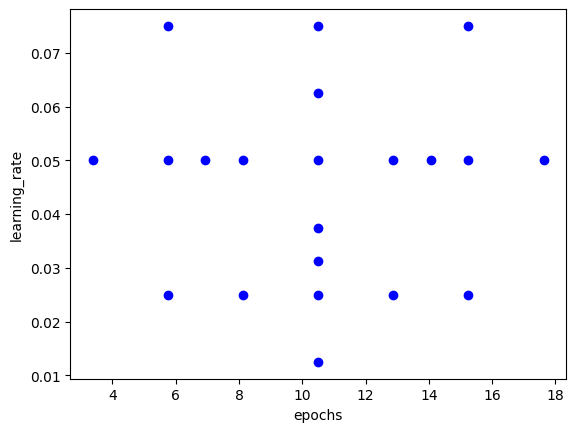

########### Interpreted Values: ###########


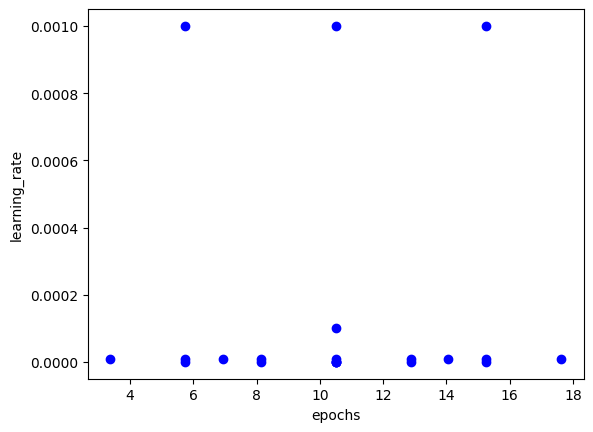

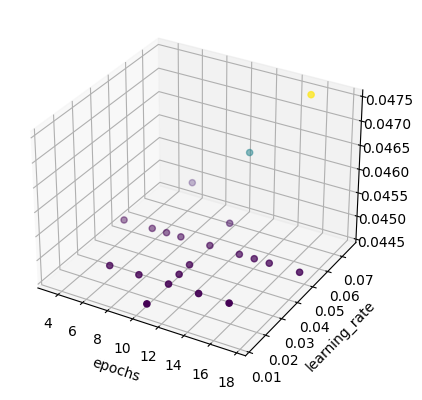

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 1e-08
Resulting loss:
0.04462808929383755
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 1e-08
Resulting loss (Optimal value from optimization):
0.04462808929383755
Resulting loss (Optimal point evaluated):
0.04462808929383755
Best score with Sparse Search: 0.04462808929383755 optimized: 0.04462808929383755
[0.044642310589551926, 0.04462846741080284, 0.04462814889848232, 0.04462809860706329]
[0.045808492228388786, 0.045808492228388786, 0.045808492228388786, 0.04279155656695366, 0.04475080966949463, 0.04409589618444443, 0.04297270067036152, 0.04322551563382149, 0.04297270067036152, 0.04297270067036152, 0.04294790141284466, 0.042821427807211876, 0.04362729378044605]
[0.04612944647669792, 0.04599708877503872, 0.04439791664481163, 0.043298400938510895, 0.04387652687728405, 0.043619729578495026, 0.042886

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 29.42996862599648 seconds
With Hyperparameters: 
epochs: 7.0
learning_rate: 0.0006850291767163728
Best score with Bayesian Optimization: 0.043489860370755196
[0.044642310589551926, 0.04462846741080284, 0.04462814889848232, 0.04462809860706329]
[0.045808492228388786, 0.045808492228388786, 0.045808492228388786, 0.04279155656695366, 0.04475080966949463, 0.04409589618444443, 0.04297270067036152, 0.04322551563382149, 0.04297270067036152, 0.04297270067036152, 0.04294790141284466, 0.042821427807211876, 0.04362729378044605, 0.042821427807211876]
[0.04612944647669792, 0.04599708877503872, 0.04439791664481163, 0.043298400938510895, 0.04387652687728405, 0.043619729578495026, 0.042886245995759964, 0.04308774322271347, 0.043307915329933167, 0.04338535666465759, 0.04298211820423603, 0.04383709654211998, 0.0435396246612072, 0.043489860370755196]
[0.044642310589551926, 0.04462821967899799, 0.04462821967899799, 0.04462815821170807, 0.04462815821170807, 0.04462808929383755]
[0.0446423105

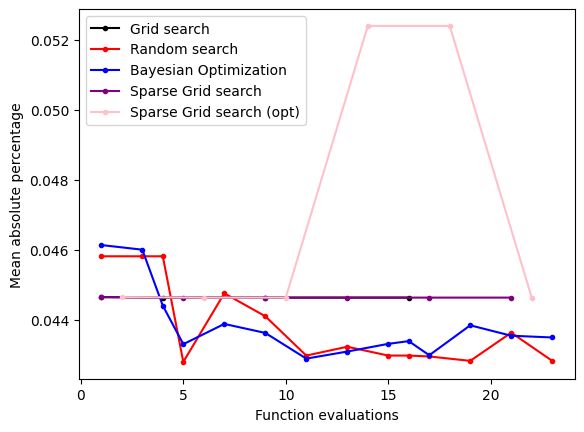

######################################################################################################################################################
Current Dataset: 4 of 5 with id: 359949
The average value for target is: tensor([540084.6250])
Min target: tensor([75000.]) Max target: tensor([7700000.])

################################################## Current Budget: 1 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 10
learning_rate: 9.999999999999997e-06
Best score with Grid search: 0.39926087856292725

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.206562839448452

Performing bayesian optimization
Iterations took 7.211289958999259 seconds
With Hyperparameters: 
epochs: 9.0
learning_rate: 0.002962759211873722
Best score with Bayesian Optimization: 0.14157340675592422

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
###########

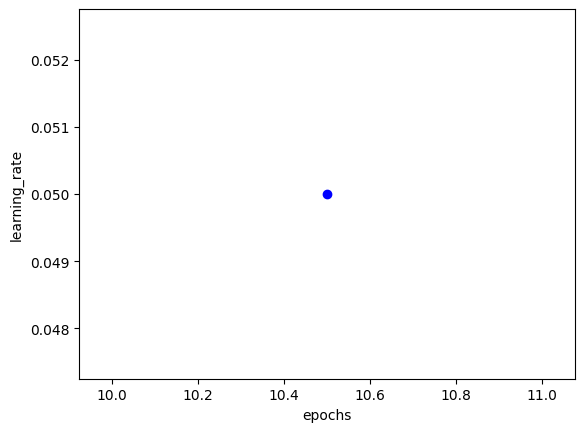

########### Interpreted Values: ###########


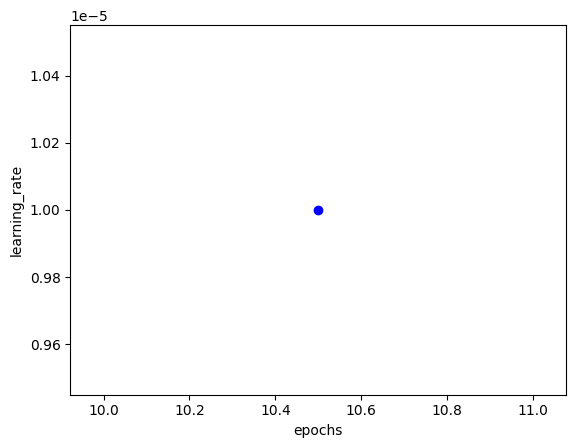

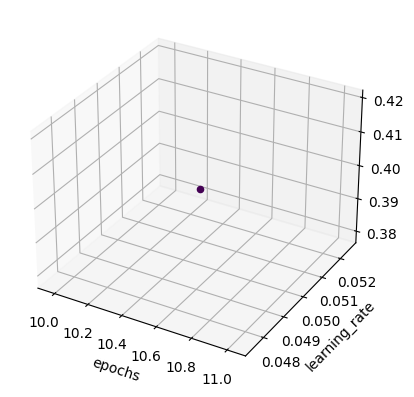

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 1e-05
Resulting loss:
0.39926087856292725
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 1e-05
Resulting loss (Optimal value from optimization):
0.39926087856292725
Resulting loss (Optimal point evaluated):
0.39926087856292725
Best score with Sparse Search: 0.39926087856292725 optimized: 0.39926087856292725
[0.39926087856292725]
[0.206562839448452]
[0.14157340675592422]
[0.39926087856292725]
[0.39926087856292725]

################################################## Current Budget: 3 ##################################################

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.206562839448452

Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 17.723030942997866 seconds
With Hyperparameters: 
epochs: 19.0
learning_rate: 0.03936985223223968
Best score with Bayesian Optimization: 0.17325837165117264
[0.39926087856292725]
[0.206562839448452, 0.206562839448452]
[0.14157340675592422, 0.17325837165117264]
[0.39926087856292725]
[0.39926087856292725]

################################################## Current Budget: 4 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 15
learning_rate: 0.0002154434690031884
Best score with Grid search: 0.15685594826936722

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.206562839448452

Performing bayesian optimization
Iterations took 14.388678596000318 seconds
With Hyperparameters: 
epochs: 8.0
learning_rate: 0.07043890313558468
Best score with Bayesian Optimization: 0.19961346685886383
[0.39926087856292725, 0.15685594826936722]
[0.206562839448452, 0.

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 22.511491213001136 seconds
With Hyperparameters: 
epochs: 8.634821568201716
learning_rate: 0.016952273103157913
Best score with Bayesian Optimization: 0.1430375799536705

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 22990ms.
########### Generated Grid: ###########


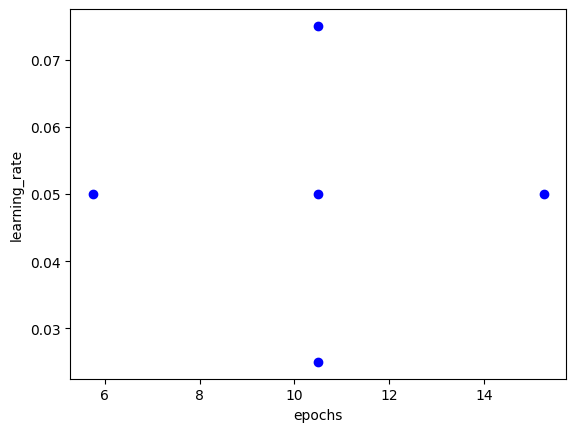

########### Interpreted Values: ###########


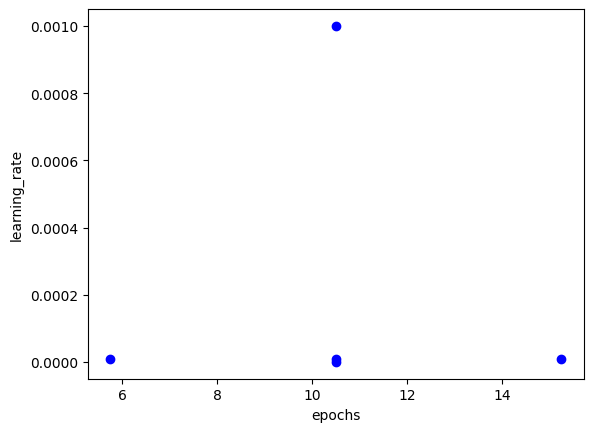

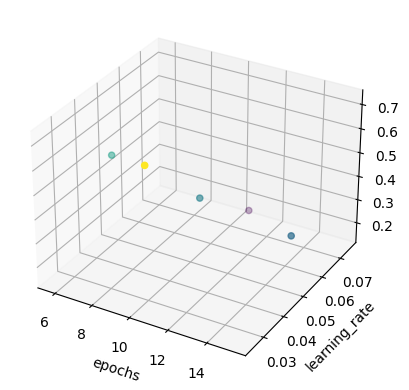

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.001
Resulting loss:
0.15441271662712097
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 0.1
Resulting loss (Optimal value from optimization):
-0.0904354453086853
Resulting loss (Optimal point evaluated):
0.30821265280246735
Best score with Sparse Search: 0.15441271662712097 optimized: 0.30821265280246735
[0.39926087856292725, 0.15685594826936722]
[0.206562839448452, 0.206562839448452, 0.206562839448452, 0.1389649584889412]
[0.14157340675592422, 0.17325837165117264, 0.19961346685886383, 0.1430375799536705]
[0.39926087856292725, 0.15441271662712097]
[0.39926087856292725, 0.30821265280246735]

################################################## Current Budget: 7 ##################################################

Performing random search
With Hyperparameters: 
epochs: 7
learning_rate: 0.030500893822737

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 40.36059533000116 seconds
With Hyperparameters: 
epochs: 16.87945845117401
learning_rate: 0.04195968572916686
Best score with Bayesian Optimization: 0.1926063522696495
[0.39926087856292725, 0.15685594826936722]
[0.206562839448452, 0.206562839448452, 0.206562839448452, 0.1389649584889412, 0.15643399953842163]
[0.14157340675592422, 0.17325837165117264, 0.19961346685886383, 0.1430375799536705, 0.1926063522696495]
[0.39926087856292725, 0.15441271662712097]
[0.39926087856292725, 0.30821265280246735]

################################################## Current Budget: 9 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 16
learning_rate: 0.0010000000000000002
Best score with Grid search: 0.14560562372207642

Performing random search
With Hyperparameters: 
epochs: 7
learning_rate: 0.030500893822737407
Best score with Random search: 0.15643399953842163

Performing bayesian optimization
Iterations took 56.231343471999935 seco

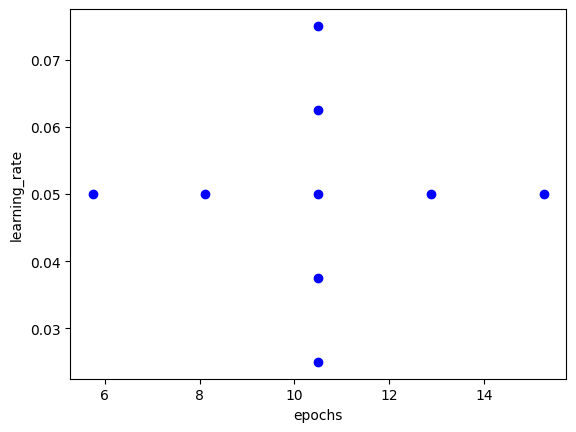

########### Interpreted Values: ###########


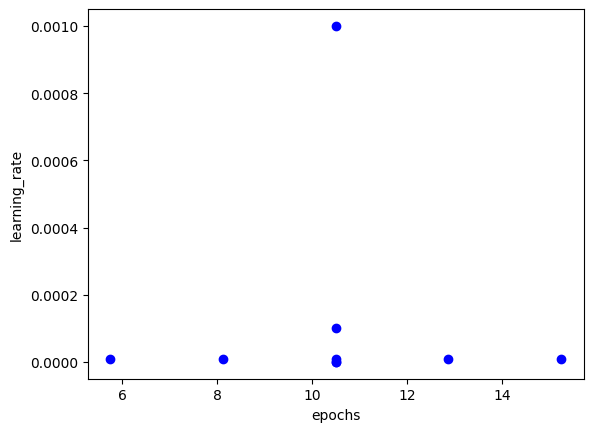

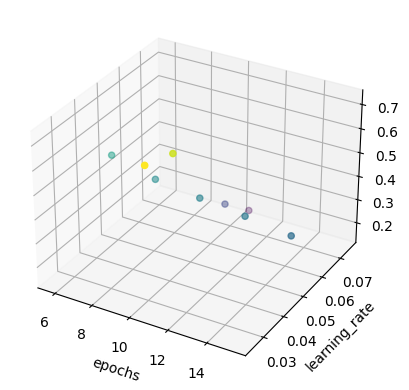

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.001
Resulting loss:
0.15441271662712097
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 19.999995263829256
learning_rate: 0.09999935801360033
Resulting loss (Optimal value from optimization):
-0.18256905691357128
Resulting loss (Optimal point evaluated):
0.959420271217823
Best score with Sparse Search: 0.15441271662712097 optimized: 0.959420271217823
[0.39926087856292725, 0.15685594826936722, 0.14560562372207642]
[0.206562839448452, 0.206562839448452, 0.206562839448452, 0.1389649584889412, 0.15643399953842163, 0.15643399953842163]
[0.14157340675592422, 0.17325837165117264, 0.19961346685886383, 0.1430375799536705, 0.1926063522696495, 0.14856388419866562]
[0.39926087856292725, 0.15441271662712097, 0.15441271662712097]
[0.39926087856292725, 0.30821265280246735, 0.959420271217823]

########################################

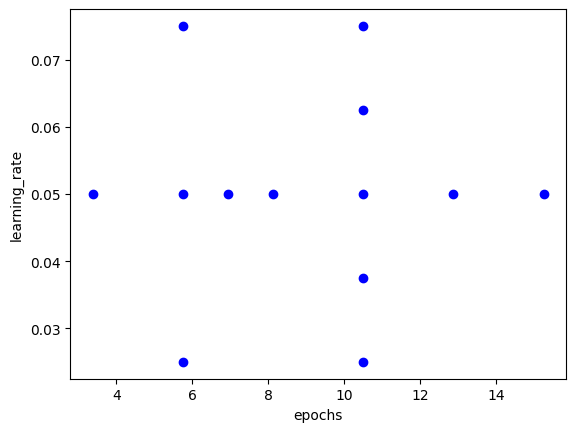

########### Interpreted Values: ###########


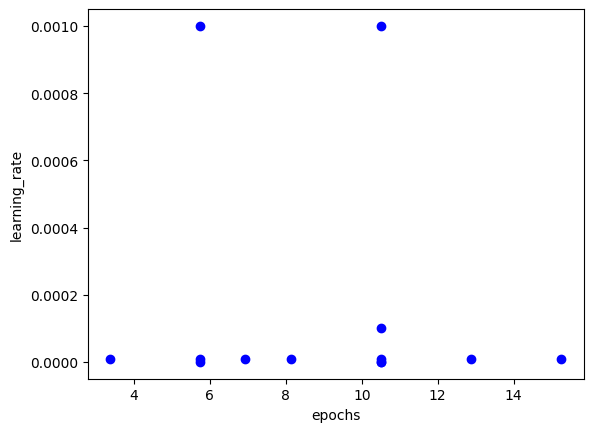

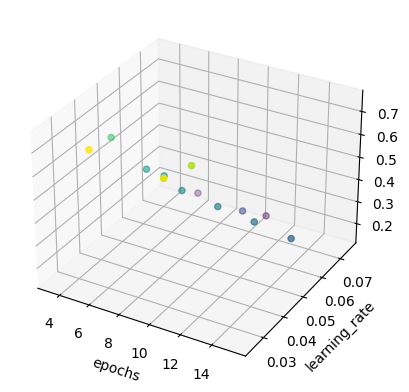

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.001
Resulting loss:
0.15441271662712097
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 5.749999824968527
learning_rate: 0.0999995402296984
Resulting loss (Optimal value from optimization):
-0.13608931612178038
Resulting loss (Optimal point evaluated):
0.19061646610498428
Best score with Sparse Search: 0.15441271662712097 optimized: 0.19061646610498428
[0.39926087856292725, 0.15685594826936722, 0.14560562372207642]
[0.206562839448452, 0.206562839448452, 0.206562839448452, 0.1389649584889412, 0.15643399953842163, 0.15643399953842163, 0.15643399953842163, 0.1410100981593132]
[0.14157340675592422, 0.17325837165117264, 0.19961346685886383, 0.1430375799536705, 0.1926063522696495, 0.14856388419866562, 0.14506659656763077, 0.1401355117559433]
[0.39926087856292725, 0.15441271662712097, 0.15441271662712097, 0.15441271662712097

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 71.16270512000119 seconds
With Hyperparameters: 
epochs: 10.196916438727868
learning_rate: 0.002274216475673746
Best score with Bayesian Optimization: 0.13701815158128738
[0.39926087856292725, 0.15685594826936722, 0.14560562372207642]
[0.206562839448452, 0.206562839448452, 0.206562839448452, 0.1389649584889412, 0.15643399953842163, 0.15643399953842163, 0.15643399953842163, 0.1410100981593132, 0.15643399953842163]
[0.14157340675592422, 0.17325837165117264, 0.19961346685886383, 0.1430375799536705, 0.1926063522696495, 0.14856388419866562, 0.14506659656763077, 0.1401355117559433, 0.13701815158128738]
[0.39926087856292725, 0.15441271662712097, 0.15441271662712097, 0.15441271662712097]
[0.39926087856292725, 0.30821265280246735, 0.959420271217823, 0.19061646610498428]

################################################## Current Budget: 16 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 12
learning_rate: 0.002511886431509

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 81.69637249799962 seconds
With Hyperparameters: 
epochs: 18.47628277135983
learning_rate: 0.0003524556196829745
Best score with Bayesian Optimization: 0.14355476200580597

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 76666ms.
########### Generated Grid: ###########


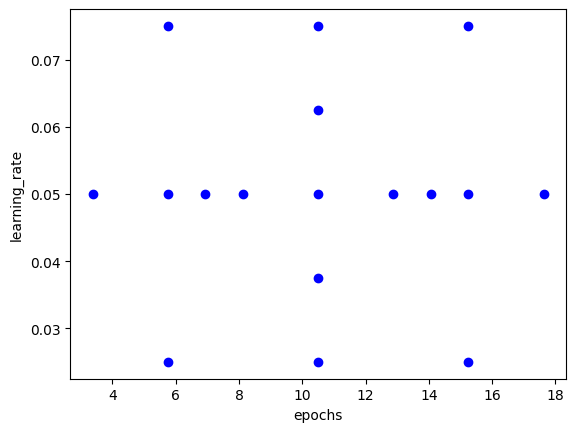

########### Interpreted Values: ###########


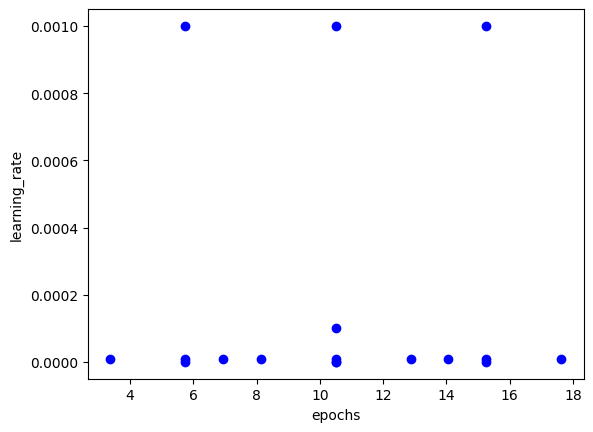

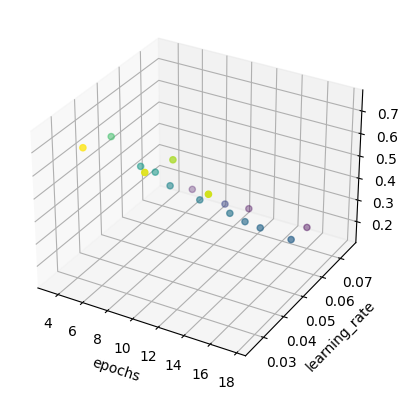

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.25
learning_rate: 0.001
Resulting loss:
0.14564330875873566
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 5.749999639977283
learning_rate: 0.09999847680542572
Resulting loss (Optimal value from optimization):
-0.1360886097759249
Resulting loss (Optimal point evaluated):
0.1970837116241455
Best score with Sparse Search: 0.14564330875873566 optimized: 0.1970837116241455
[0.39926087856292725, 0.15685594826936722, 0.14560562372207642, 0.13533343374729156]
[0.206562839448452, 0.206562839448452, 0.206562839448452, 0.1389649584889412, 0.15643399953842163, 0.15643399953842163, 0.15643399953842163, 0.1410100981593132, 0.15643399953842163, 0.14322061836719513, 0.14047017693519592]
[0.14157340675592422, 0.17325837165117264, 0.19961346685886383, 0.1430375799536705, 0.1926063522696495, 0.14856388419866562, 0.14506659656763077, 0.1401355117559433, 

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 102.4984749699961 seconds
With Hyperparameters: 
epochs: 13.24220216616849
learning_rate: 0.0024320458406545723
Best score with Bayesian Optimization: 0.13917245715856552
[0.39926087856292725, 0.15685594826936722, 0.14560562372207642, 0.13533343374729156]
[0.206562839448452, 0.206562839448452, 0.206562839448452, 0.1389649584889412, 0.15643399953842163, 0.15643399953842163, 0.15643399953842163, 0.1410100981593132, 0.15643399953842163, 0.14322061836719513, 0.14047017693519592, 0.14322061836719513]
[0.14157340675592422, 0.17325837165117264, 0.19961346685886383, 0.1430375799536705, 0.1926063522696495, 0.14856388419866562, 0.14506659656763077, 0.1401355117559433, 0.13701815158128738, 0.13790983706712723, 0.14355476200580597, 0.13917245715856552]
[0.39926087856292725, 0.15441271662712097, 0.15441271662712097, 0.15441271662712097, 0.14564330875873566]
[0.39926087856292725, 0.30821265280246735, 0.959420271217823, 0.19061646610498428, 0.1970837116241455]

#######################

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 97.59170952100249 seconds
With Hyperparameters: 
epochs: 19.0
learning_rate: 0.0020310173004870085
Best score with Bayesian Optimization: 0.13895020633935928

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 106106ms.
########### Generated Grid: ###########


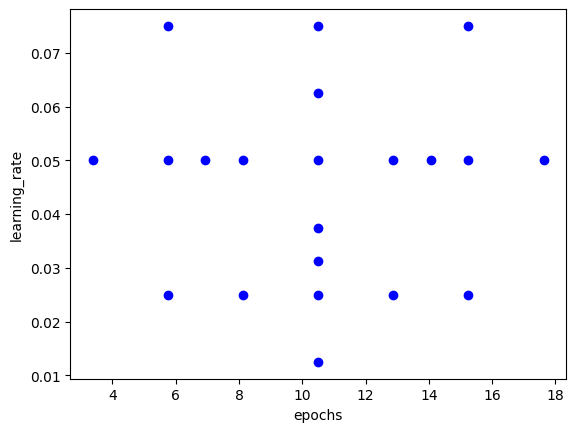

########### Interpreted Values: ###########


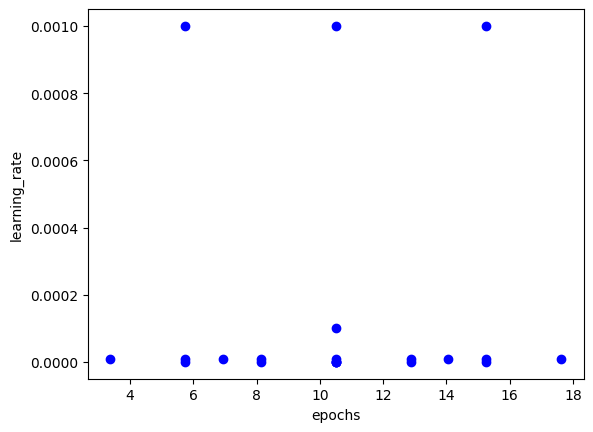

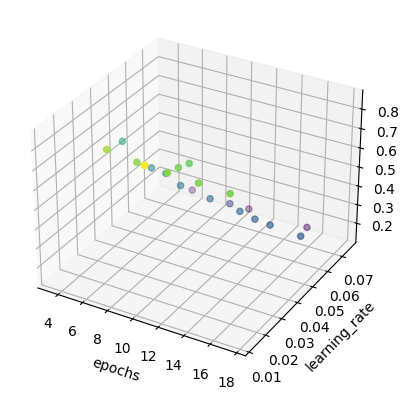

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.25
learning_rate: 0.001
Resulting loss:
0.14564330875873566
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 5.749999639977283
learning_rate: 0.09999847680542572
Resulting loss (Optimal value from optimization):
-0.1360886097759249
Resulting loss (Optimal point evaluated):
0.1970837116241455
Best score with Sparse Search: 0.14564330875873566 optimized: 0.1970837116241455
[0.39926087856292725, 0.15685594826936722, 0.14560562372207642, 0.13533343374729156]
[0.206562839448452, 0.206562839448452, 0.206562839448452, 0.1389649584889412, 0.15643399953842163, 0.15643399953842163, 0.15643399953842163, 0.1410100981593132, 0.15643399953842163, 0.14322061836719513, 0.14047017693519592, 0.14322061836719513, 0.1434425413608551]
[0.14157340675592422, 0.17325837165117264, 0.19961346685886383, 0.1430375799536705, 0.1926063522696495, 0.14856388419866562, 

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 100.45597003200237 seconds
With Hyperparameters: 
epochs: 18.406104161444638
learning_rate: 0.0019458907175212885
Best score with Bayesian Optimization: 0.1381811648607254
[0.39926087856292725, 0.15685594826936722, 0.14560562372207642, 0.13533343374729156]
[0.206562839448452, 0.206562839448452, 0.206562839448452, 0.1389649584889412, 0.15643399953842163, 0.15643399953842163, 0.15643399953842163, 0.1410100981593132, 0.15643399953842163, 0.14322061836719513, 0.14047017693519592, 0.14322061836719513, 0.1434425413608551, 0.14322061836719513]
[0.14157340675592422, 0.17325837165117264, 0.19961346685886383, 0.1430375799536705, 0.1926063522696495, 0.14856388419866562, 0.14506659656763077, 0.1401355117559433, 0.13701815158128738, 0.13790983706712723, 0.14355476200580597, 0.13917245715856552, 0.13895020633935928, 0.1381811648607254]
[0.39926087856292725, 0.15441271662712097, 0.15441271662712097, 0.15441271662712097, 0.14564330875873566, 0.14564330875873566]
[0.39926087856292725, 0

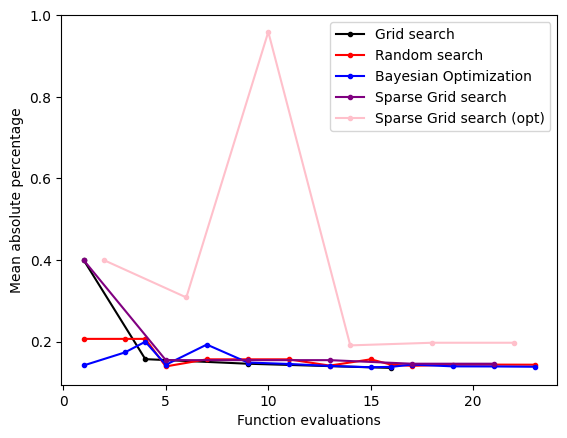

######################################################################################################################################################
Current Dataset: 5 of 5 with id: 359938
The average value for target is: tensor([5490.4849])
Min target: tensor([499.]) Max target: tensor([1120000.])

################################################## Current Budget: 1 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 10
learning_rate: 9.999999999999997e-06
Best score with Grid search: 4.275510907173157

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.49861159920692444

Performing bayesian optimization
Iterations took 4.095859091999955 seconds
With Hyperparameters: 
epochs: 9.0
learning_rate: 0.002962759211873722
Best score with Bayesian Optimization: 0.2112300917506218

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
########### Gene

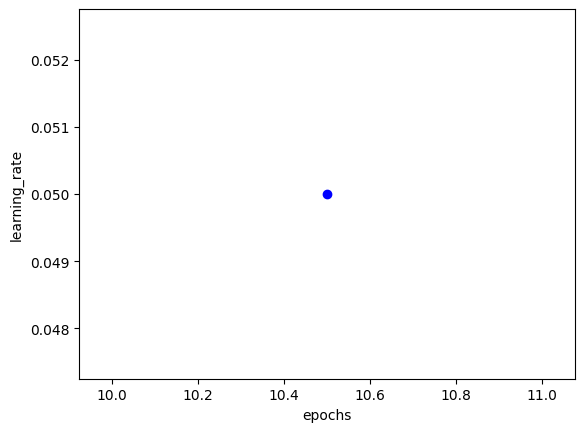

########### Interpreted Values: ###########


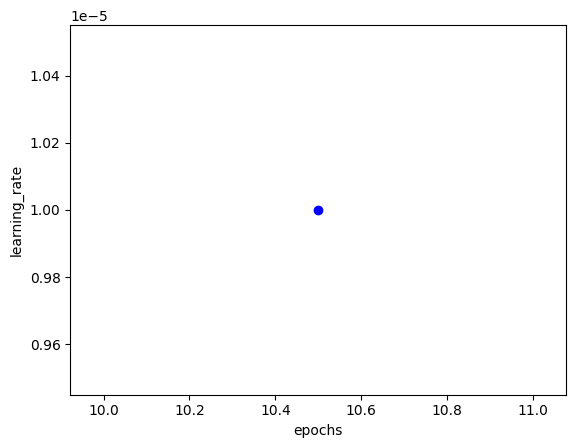

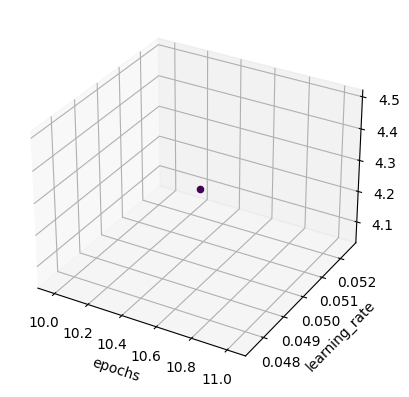


Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 1e-05
Resulting loss:
4.275510907173157
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 1e-05
Resulting loss (Optimal value from optimization):
4.275510907173157
Resulting loss (Optimal point evaluated):
4.275510907173157
Best score with Sparse Search: 4.275510907173157 optimized: 4.275510907173157
[4.275510907173157]
[0.49861159920692444]
[0.2112300917506218]
[4.275510907173157]
[4.275510907173157]

################################################## Current Budget: 3 ##################################################

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.49861159920692444

Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 11.465630867998698 seconds
With Hyperparameters: 
epochs: 19.0
learning_rate: 0.03936985223223968
Best score with Bayesian Optimization: 0.06721797399222851
[4.275510907173157]
[0.49861159920692444, 0.49861159920692444]
[0.2112300917506218, 0.06721797399222851]
[4.275510907173157]
[4.275510907173157]

################################################## Current Budget: 4 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 15
learning_rate: 0.0002154434690031884
Best score with Grid search: 0.8875743746757507

Performing random search
With Hyperparameters: 
epochs: 6
learning_rate: 0.09494639669696203
Best score with Random search: 0.49861159920692444

Performing bayesian optimization
Iterations took 11.044806047000748 seconds
With Hyperparameters: 
epochs: 18.0
learning_rate: 0.00044632010537780603
Best score with Bayesian Optimization: 0.2504965588450432
[4.275510907173157, 0.8875743746757507]
[0.49861159920692444, 0.

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 14.749768780000522 seconds
With Hyperparameters: 
epochs: 8.0
learning_rate: 0.010090887667110597
Best score with Bayesian Optimization: 0.10607055947184563

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 14044ms.
########### Generated Grid: ###########


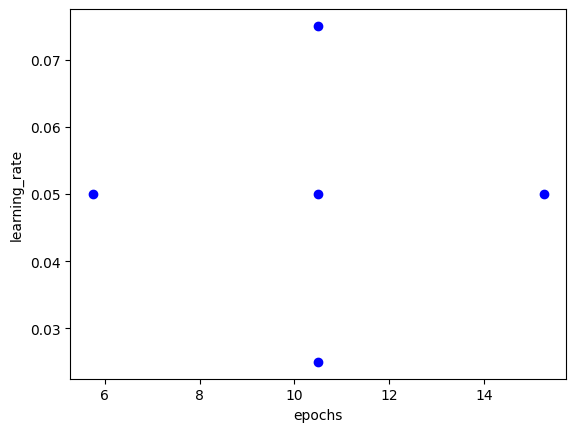

########### Interpreted Values: ###########


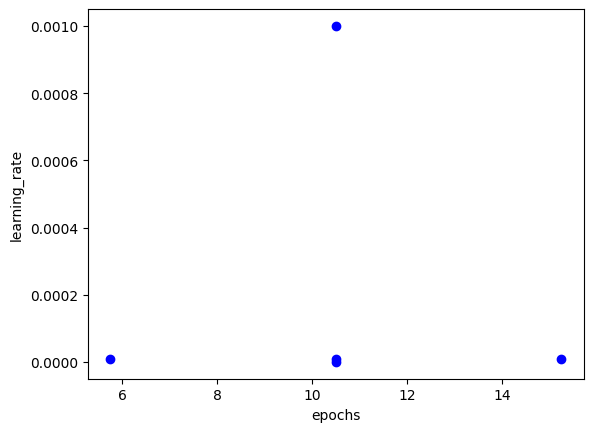

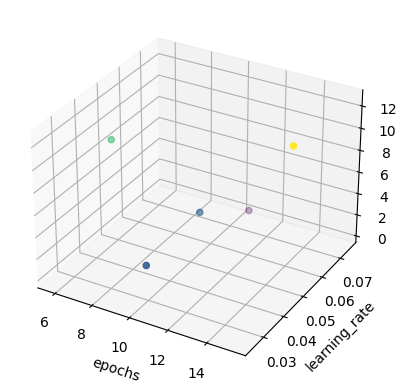

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.001
Resulting loss:
0.25493448227643967
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 0.1
Resulting loss (Optimal value from optimization):
-3.7656419426202774
Resulting loss (Optimal point evaluated):
0.5442098081111908
Best score with Sparse Search: 0.25493448227643967 optimized: 0.5442098081111908
[4.275510907173157, 0.8875743746757507]
[0.49861159920692444, 0.49861159920692444, 0.49861159920692444, 0.21717505156993866]
[0.2112300917506218, 0.06721797399222851, 0.2504965588450432, 0.10607055947184563]
[4.275510907173157, 0.25493448227643967]
[4.275510907173157, 0.5442098081111908]

################################################## Current Budget: 7 ##################################################

Performing random search
With Hyperparameters: 
epochs: 7
learning_rate: 0.030500893822737407


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 24.821288306997303 seconds
With Hyperparameters: 
epochs: 17.850813949697656
learning_rate: 0.007770679344438272
Best score with Bayesian Optimization: 0.06499006226658821
[4.275510907173157, 0.8875743746757507]
[0.49861159920692444, 0.49861159920692444, 0.49861159920692444, 0.21717505156993866, 0.14960936456918716]
[0.2112300917506218, 0.06721797399222851, 0.2504965588450432, 0.10607055947184563, 0.06499006226658821]
[4.275510907173157, 0.25493448227643967]
[4.275510907173157, 0.5442098081111908]

################################################## Current Budget: 9 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 16
learning_rate: 0.0010000000000000002
Best score with Grid search: 0.15093685686588287

Performing random search
With Hyperparameters: 
epochs: 7
learning_rate: 0.030500893822737407
Best score with Random search: 0.14960936456918716

Performing bayesian optimization
Iterations took 34.06724004900025 se

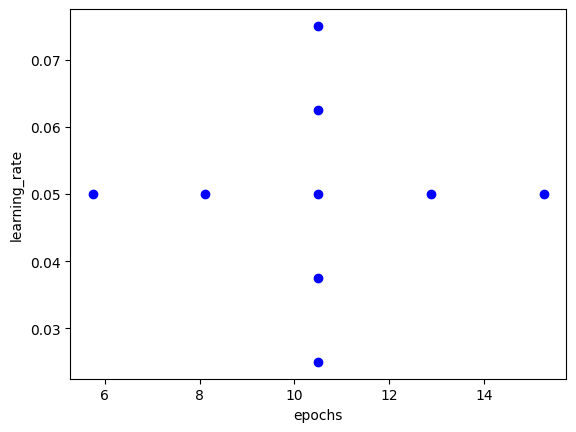

########### Interpreted Values: ###########


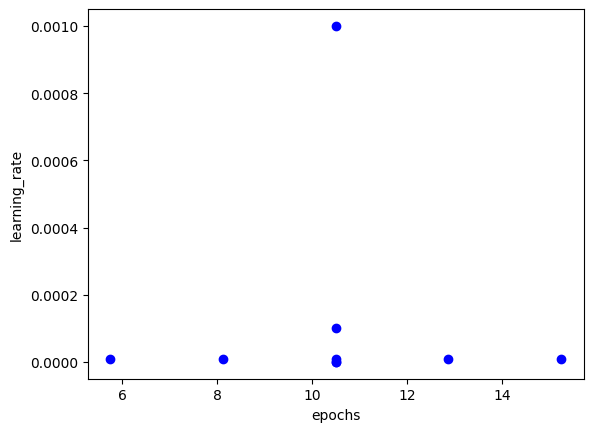

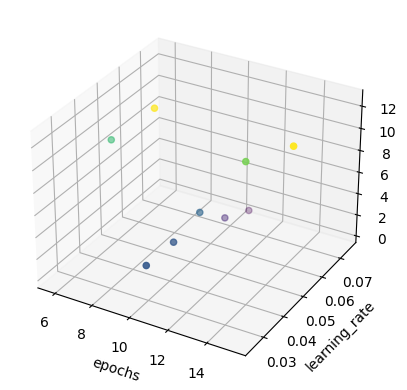

Solving linear system (automatic method)...

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.001
Resulting loss:
0.25493448227643967
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 0.001
Resulting loss (Optimal value from optimization):
0.25493448227643967
Resulting loss (Optimal point evaluated):
0.25493448227643967
Best score with Sparse Search: 0.25493448227643967 optimized: 0.25493448227643967
[4.275510907173157, 0.8875743746757507, 0.15093685686588287]
[0.49861159920692444, 0.49861159920692444, 0.49861159920692444, 0.21717505156993866, 0.14960936456918716, 0.14960936456918716]
[0.2112300917506218, 0.06721797399222851, 0.2504965588450432, 0.10607055947184563, 0.06499006226658821, 0.10102255642414093]
[4.275510907173157, 0.25493448227643967, 0.25493448227643967]
[4.275510907173157, 0.5442098081111908, 0.25493448227643967]

################################################## Current Budge

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 31.96046234000096 seconds
With Hyperparameters: 
epochs: 5.0
learning_rate: 0.01576175998969297
Best score with Bayesian Optimization: 0.13506952673196793
[4.275510907173157, 0.8875743746757507, 0.15093685686588287]
[0.49861159920692444, 0.49861159920692444, 0.49861159920692444, 0.21717505156993866, 0.14960936456918716, 0.14960936456918716, 0.14960936456918716]
[0.2112300917506218, 0.06721797399222851, 0.2504965588450432, 0.10607055947184563, 0.06499006226658821, 0.10102255642414093, 0.13506952673196793]
[4.275510907173157, 0.25493448227643967, 0.25493448227643967]
[4.275510907173157, 0.5442098081111908, 0.25493448227643967]

################################################## Current Budget: 13 ##################################################

Performing random search
With Hyperparameters: 
epochs: 11
learning_rate: 0.008136064013517868
Best score with Random search: 0.09218232706189156

Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 44.927679438005725 seconds
With Hyperparameters: 
epochs: 19.0
learning_rate: 0.009902518412290737
Best score with Bayesian Optimization: 0.06708003021776676

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 40384ms.
########### Generated Grid: ###########


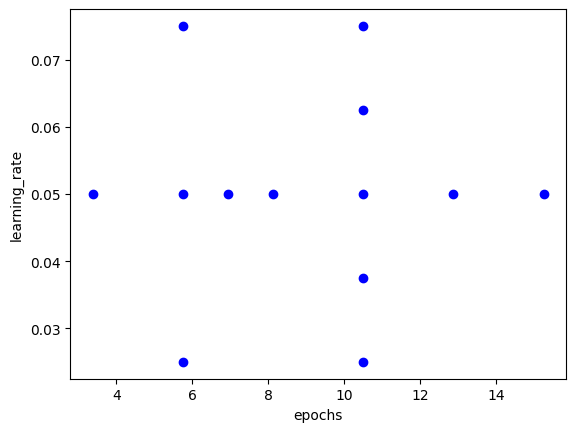

########### Interpreted Values: ###########


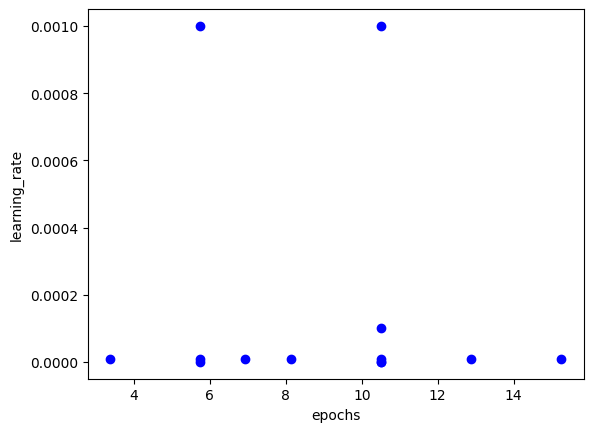

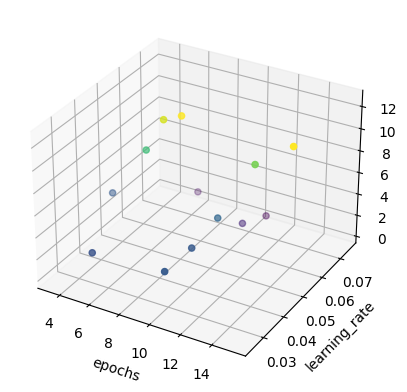

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 10.5
learning_rate: 0.001
Resulting loss:
0.25493448227643967
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 10.5
learning_rate: 0.001
Resulting loss (Optimal value from optimization):
0.25493448227643967
Resulting loss (Optimal point evaluated):
0.25493448227643967
Best score with Sparse Search: 0.25493448227643967 optimized: 0.25493448227643967
[4.275510907173157, 0.8875743746757507, 0.15093685686588287]
[0.49861159920692444, 0.49861159920692444, 0.49861159920692444, 0.21717505156993866, 0.14960936456918716, 0.14960936456918716, 0.14960936456918716, 0.09218232706189156]
[0.2112300917506218, 0.06721797399222851, 0.2504965588450432, 0.10607055947184563, 0.06499006226658821, 0.10102255642414093, 0.13506952673196793, 0.06708003021776676]
[4.275510907173157, 0.25493448227643967, 0.25493448227643967, 0.25493448227643967]
[4.275510907173157, 0

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 50.18676296700505 seconds
With Hyperparameters: 
epochs: 9.901349406125764
learning_rate: 0.007232017045832797
Best score with Bayesian Optimization: 0.10401777178049088
[4.275510907173157, 0.8875743746757507, 0.15093685686588287]
[0.49861159920692444, 0.49861159920692444, 0.49861159920692444, 0.21717505156993866, 0.14960936456918716, 0.14960936456918716, 0.14960936456918716, 0.09218232706189156, 0.14960936456918716]
[0.2112300917506218, 0.06721797399222851, 0.2504965588450432, 0.10607055947184563, 0.06499006226658821, 0.10102255642414093, 0.13506952673196793, 0.06708003021776676, 0.10401777178049088]
[4.275510907173157, 0.25493448227643967, 0.25493448227643967, 0.25493448227643967]
[4.275510907173157, 0.5442098081111908, 0.25493448227643967, 0.25493448227643967]

################################################## Current Budget: 16 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 17
learning_rate: 0.0025118864315

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 50.948997789000714 seconds
With Hyperparameters: 
epochs: 11.0
learning_rate: 0.00321244054952608
Best score with Bayesian Optimization: 0.1501217633485794
[4.275510907173157, 0.8875743746757507, 0.15093685686588287, 0.1206122636795044]
[0.49861159920692444, 0.49861159920692444, 0.49861159920692444, 0.21717505156993866, 0.14960936456918716, 0.14960936456918716, 0.14960936456918716, 0.09218232706189156, 0.14960936456918716, 0.14282875880599022]
[0.2112300917506218, 0.06721797399222851, 0.2504965588450432, 0.10607055947184563, 0.06499006226658821, 0.10102255642414093, 0.13506952673196793, 0.06708003021776676, 0.10401777178049088, 0.1501217633485794]
[4.275510907173157, 0.25493448227643967, 0.25493448227643967, 0.25493448227643967]
[4.275510907173157, 0.5442098081111908, 0.25493448227643967, 0.25493448227643967]

################################################## Current Budget: 17 ##################################################

Performing random search
With Hyperparam

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 61.550708162991214 seconds
With Hyperparameters: 
epochs: 13.295805659598516
learning_rate: 0.008149517787298128
Best score with Bayesian Optimization: 0.0773206315934658

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 51799ms.
########### Generated Grid: ###########


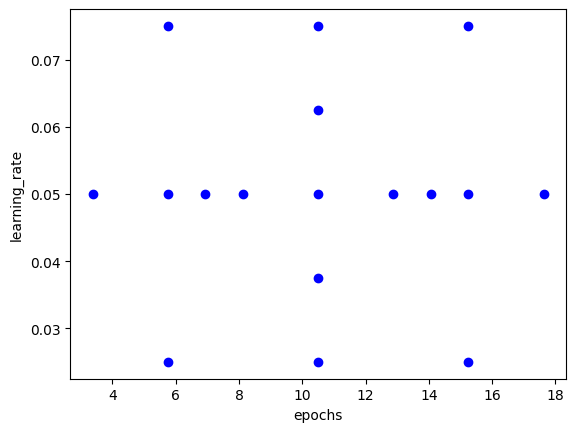

########### Interpreted Values: ###########


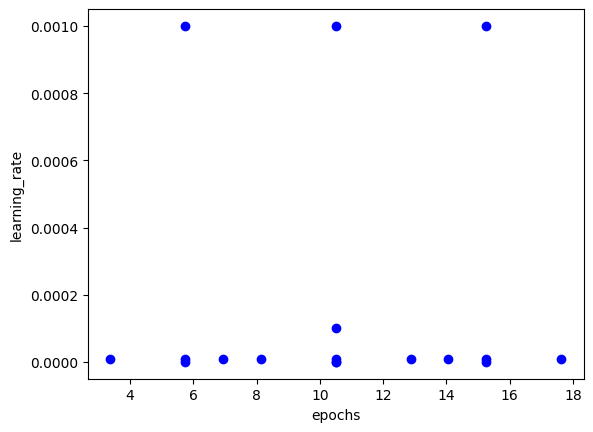

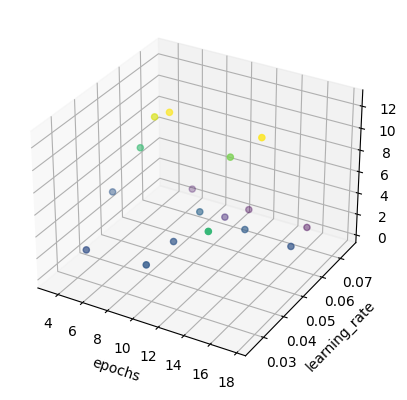

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.25
learning_rate: 0.001
Resulting loss:
0.1652887761592865
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 19.999992887783336
learning_rate: 0.09999976372936029
Resulting loss (Optimal value from optimization):
-46.809396031801654
Resulting loss (Optimal point evaluated):
0.7133594155311584
Best score with Sparse Search: 0.1652887761592865 optimized: 0.7133594155311584
[4.275510907173157, 0.8875743746757507, 0.15093685686588287, 0.1206122636795044]
[0.49861159920692444, 0.49861159920692444, 0.49861159920692444, 0.21717505156993866, 0.14960936456918716, 0.14960936456918716, 0.14960936456918716, 0.09218232706189156, 0.14960936456918716, 0.14282875880599022, 0.1564001590013504]
[0.2112300917506218, 0.06721797399222851, 0.2504965588450432, 0.10607055947184563, 0.06499006226658821, 0.10102255642414093, 0.13506952673196793, 0.0670800302177667

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 62.57154830399668 seconds
With Hyperparameters: 
epochs: 18.002453971606343
learning_rate: 0.0019937541393068854
Best score with Bayesian Optimization: 0.15226026624441147
[4.275510907173157, 0.8875743746757507, 0.15093685686588287, 0.1206122636795044]
[0.49861159920692444, 0.49861159920692444, 0.49861159920692444, 0.21717505156993866, 0.14960936456918716, 0.14960936456918716, 0.14960936456918716, 0.09218232706189156, 0.14960936456918716, 0.14282875880599022, 0.1564001590013504, 0.14282875880599022]
[0.2112300917506218, 0.06721797399222851, 0.2504965588450432, 0.10607055947184563, 0.06499006226658821, 0.10102255642414093, 0.13506952673196793, 0.06708003021776676, 0.10401777178049088, 0.1501217633485794, 0.0773206315934658, 0.15226026624441147]
[4.275510907173157, 0.25493448227643967, 0.25493448227643967, 0.25493448227643967, 0.1652887761592865]
[4.275510907173157, 0.5442098081111908, 0.25493448227643967, 0.25493448227643967, 0.7133594155311584]

########################

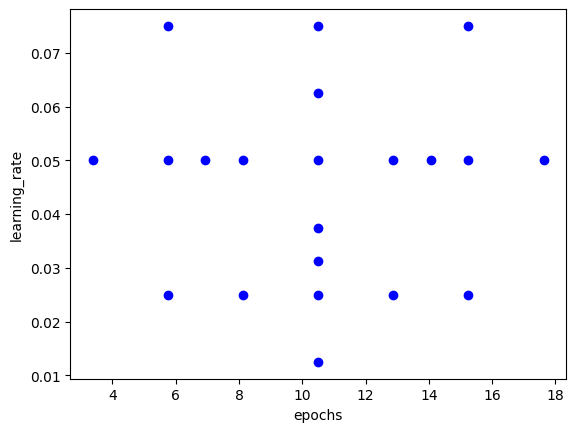

########### Interpreted Values: ###########


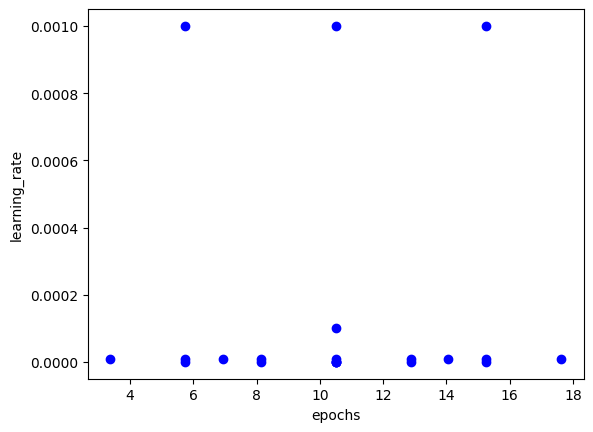

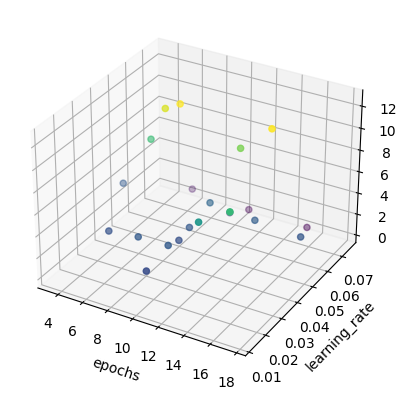

Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 15.25
learning_rate: 0.001
Resulting loss:
0.1652887761592865
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 19.999992887783336
learning_rate: 0.09999976372936029
Resulting loss (Optimal value from optimization):
-46.809396031801654
Resulting loss (Optimal point evaluated):
0.7133594155311584
Best score with Sparse Search: 0.1652887761592865 optimized: 0.7133594155311584
[4.275510907173157, 0.8875743746757507, 0.15093685686588287, 0.1206122636795044]
[0.49861159920692444, 0.49861159920692444, 0.49861159920692444, 0.21717505156993866, 0.14960936456918716, 0.14960936456918716, 0.14960936456918716, 0.09218232706189156, 0.14960936456918716, 0.14282875880599022, 0.1564001590013504, 0.14282875880599022, 0.09641700237989426]
[0.2112300917506218, 0.06721797399222851, 0.2504965588450432, 0.10607055947184563, 0.06499006226658821, 0.1010225564241409

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 60.4450345960031 seconds
With Hyperparameters: 
epochs: 14.0
learning_rate: 0.0012384286758491154
Best score with Bayesian Optimization: 0.19970494508743286
[4.275510907173157, 0.8875743746757507, 0.15093685686588287, 0.1206122636795044]
[0.49861159920692444, 0.49861159920692444, 0.49861159920692444, 0.21717505156993866, 0.14960936456918716, 0.14960936456918716, 0.14960936456918716, 0.09218232706189156, 0.14960936456918716, 0.14282875880599022, 0.1564001590013504, 0.14282875880599022, 0.09641700237989426, 0.14282875880599022]
[0.2112300917506218, 0.06721797399222851, 0.2504965588450432, 0.10607055947184563, 0.06499006226658821, 0.10102255642414093, 0.13506952673196793, 0.06708003021776676, 0.10401777178049088, 0.1501217633485794, 0.0773206315934658, 0.15226026624441147, 0.06104729883372784, 0.19970494508743286]
[4.275510907173157, 0.25493448227643967, 0.25493448227643967, 0.25493448227643967, 0.1652887761592865, 0.1652887761592865]
[4.275510907173157, 0.5442098081111908

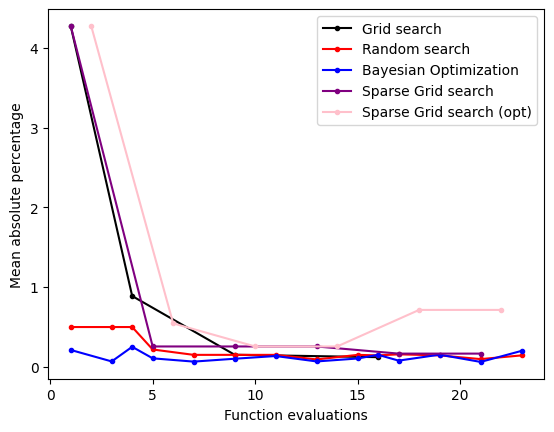

In [34]:
os.mkdir(DIRECTORY)

f = open(DIRECTORY+"/configurations.txt", "a")
f.write("Dimension of hyperparameter space: " + str(len(hyperparameterspace)) + "\n")
for key in hyperparameterspace.keys():
    f.write("\n" + key + ": " + str(hyperparameterspace[key]))
f.write("\n\nSparse grid degree: " + str(SPARSE_PARAMS[0]))
f.write("\nSparse grid adaptivity param: " + str(SPARSE_PARAMS[1]))
f.write("\nSparse grid optimization alg: " + str(SPARSE_PARAMS[2]))
f.write("\nBUDGETS: " + str(BUDGETS))
f.close()

ids = [233211, 359952, 359931, 359949, 359938]
# [359940, 317614, 359934, 359946, 359932, 233214, 359943]

for i in range(len(ids)):
    print("######################################################################################################################################################")
    print("Current Dataset:", (i+1), "of", len(ids), "with id:", ids[i])

    dataset = HPO.Dataset(task_id=ids[i])

    print("The average value for target is:", sum(
        dataset.get_Y()/len(dataset.get_Y())))
    print("Min target:", min(dataset.get_Y()),
          "Max target:", max(dataset.get_Y()))

    current_dataset_grid = []
    current_dataset_random = []
    current_dataset_bayesian = []
    current_dataset_sparse = []
    current_dataset_sparse_opt = []

    current_dataset_grid_cost = []
    current_dataset_random_cost = []
    current_dataset_bayesian_cost = []
    current_dataset_sparse_cost = []
    current_dataset_sparse_opt_cost = []

    ################## MODEL AND FUNCTION DEFINITION ####################

    def evaluate_model(epochs, batch_size, learning_rate, number_of_layers, neurons_per_layer, deterministic=True):

        # return epochs + batch_size + learning_rate + number_of_layers + neurons_per_layer

        kfold = KFold(n_splits=CV)

        split = (kfold.split(dataset.get_X(), dataset.get_Y()))

        values = []

        numeric_features = [not x for x in dataset.get_categorical_indicator()]
        numeric_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")),
                   ("scaler", StandardScaler())]
        )

        categorical_transformer = Pipeline(
            steps=[
                ("encoder", OneHotEncoder(
                    handle_unknown="infrequent_if_exist", sparse_output=False)),
                # ("selector", SelectPercentile(chi2, percentile=50)),
            ]
        )

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer,
                 dataset.get_categorical_indicator()),
            ]
        )

        for i, (train_index, test_index) in enumerate(split):

            if deterministic:
                reset_seeds()

            X_train = dataset.get_X()[train_index]
            Y_train = dataset.get_Y()[train_index]

            X_val = dataset.get_X()[test_index]
            Y_val = dataset.get_Y()[test_index]

            preprocessor.fit(X_train, Y_train)

            X_train = preprocessor.transform(X_train)
            X_val = preprocessor.transform(X_val)

            regressor = KerasRegressor(model=create_model,
                                       learning_rate=learning_rate,
                                       input_dim=len(
                                           X_train[0]),
                                       number_layers=number_of_layers,
                                       neurons_per_layer=neurons_per_layer,
                                       verbose=0)

            regressor = TransformedTargetRegressor(regressor=regressor,
                                                   transformer=StandardScaler())

            regressor.fit(X_train, Y_train, epochs=epochs,
                          batch_size=batch_size, shuffle=False)

            Y_predicted = regressor.predict(X_val)
            # error = sklearn.metrics.mean_absolute_error(Y_predicted, Y_val)
            error = sklearn.metrics.mean_absolute_percentage_error(
                Y_predicted, Y_val)
            values.append(error)

            del regressor
            K.clear_session()

        result = sum(values)/len(values)
        return result

    def blackboxfunction_grid(params):
        # index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        # hyperparameterspace_special["loss"][index]

        epochs = int(params[0])

        batch_size = 100 # int(params[1])

        learning_rate = params[1]

        number_of_layers = 1  # int(params[3])

        neurons_per_layer = 40  # int(params[4])

        return evaluate_model(epochs, batch_size, learning_rate, number_of_layers, neurons_per_layer)

    def blackboxfunction_random(params):
        # index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        # hyperparameterspace_special["loss"][index]

        epochs = int(params[0])

        batch_size = 100 # int(params[1])

        learning_rate = params[1]

        number_of_layers = 1  # int(params[3])

        neurons_per_layer = 40  # int(params[4])

        return evaluate_model(epochs, batch_size, learning_rate, number_of_layers, neurons_per_layer, deterministic=False)

    def blackboxfunction_bayesian(params):
        # index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        # hyperparameterspace_special["loss"][index]

        epochs = int(params[0])

        batch_size = 100 # int(params[1])

        model_learning_rate = 10 ** (params[1])

        number_of_layers = 1  # int(params[3])

        neurons_per_layer = 40  # int(params[4])

        return evaluate_model(epochs, batch_size, model_learning_rate, number_of_layers, neurons_per_layer, deterministic=False)

    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(
                len(hyperparameterspace.keys()))

        def eval(self, x):
            # index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            # hyperparameterspace_special["loss"][index]

            epochs = int(HPO.from_standard(
                hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

            batch_size = 100 # int(HPO.from_standard(
                # hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

            model_learning_rate = HPO.from_standard_log(hyperparameterspace_special["learning_rate"][
                                                        0], hyperparameterspace_special["learning_rate"][1], x[1])

            number_of_layers = 1  # int(HPO.from_standard(
            # hyperparameterspace_special["number_layers"][0], hyperparameterspace_special["number_layers"][1], x[3]))

            neurons_per_layer = 40  # int(HPO.from_standard(
            # hyperparameterspace_special["neurons_per_layer"][0], hyperparameterspace_special["neurons_per_layer"][1], x[4]))

            return evaluate_model(epochs, batch_size, model_learning_rate, number_of_layers, neurons_per_layer)

    ##### For each dataset: run models with different budget #####
    for BUDGET in BUDGETS:

        print("\n################################################## Current Budget:",
              BUDGET, "##################################################")

        ############################## GRID SEARCH #######################
        grid_sizes = [x ** len(hyperparameterspace) for x in range(9)]
        if BUDGET in grid_sizes:
            print("\nPerforming grid search")
            optimization = HPO.GridSearchOptimization(
                dataset, blackboxfunction_grid, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

            result, cost = optimization.fit()

            index_best = 0
            for m in range(len(result)):
                if result[m][1] < result[index_best][1]:
                    index_best = m

            best_score = result[index_best][1]
            best_params = result[index_best][0]

            if VERBOSE > 0:
                print("With Hyperparameters: ")
                m = 0
                for key in hyperparameterspace.keys():
                    if hyperparameterspace[key][0] == "list":
                        index = int(
                            best_params[m]*(len(hyperparameterspace_special[key])-1))
                        print(key + ": " +
                              str(hyperparameterspace_special[key][index]))
                    else:
                        print(key + ": " + str(best_params[m]))
                    m += 1

            print("Best score with Grid search:", best_score)

            current_dataset_grid.append(best_score)
            current_dataset_grid_cost.append(cost)

            K.clear_session()

        # ########################### RANDOM SEARCH #######################
        print("\nPerforming random search")

        optimization = HPO.RandomSearchOptimization(
            dataset, blackboxfunction_random, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        index_best = 0
        for m in range(len(result)):
            if result[m][1] < result[index_best][1]:
                index_best = m

        best_score = result[index_best][1]
        best_params = result[index_best][0]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            m = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(
                        best_params[m]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " +
                          str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[m]))
                m += 1

        print("Best score with Random search:", best_score)

        current_dataset_random.append(best_score)
        current_dataset_random_cost.append(cost)

        K.clear_session()

        ########################### BAYESIAN OPT #####################
        print("\nPerforming bayesian optimization")

        optimization = HPO.BayesianOptimization(
            dataset, blackboxfunction_bayesian, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)

        result, cost = optimization.fit()

        index_best = 0
        for m in range(len(result)):
            if result[m][1] < result[index_best][1]:
                index_best = m

        best_score = result[index_best][1]
        best_params = result[index_best][0]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            m = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(
                        best_params[m]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " +
                          str(hyperparameterspace_special[key][index]))
                elif hyperparameterspace[key][0] == "interval-log":
                    print(key + ": " + str(10 ** best_params[m]))
                else:
                    print(key + ": " + str(best_params[m]))
                m += 1

        print("Best score with Bayesian Optimization:", best_score)

        current_dataset_bayesian.append(best_score)
        current_dataset_bayesian_cost.append(BUDGET)

        K.clear_session()

        ########################### SPARSE OPT ############################

        costs_sparse = [1]
        for _ in range(40):
            costs_sparse.append(costs_sparse[-1]+2*len(hyperparameterspace))

        if BUDGET in costs_sparse:
            print("\nPerforming sparse search")

            f = ExampleFunction()

            optimization = HPO.SparseGridSearchOptimization(
                dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=SPARSE_PARAMS[0], adaptivity=SPARSE_PARAMS[1], optimizer=SPARSE_PARAMS[2])

            result = optimization.fit()

            print("Best score with Sparse Search:",
                  result[0][1], "optimized:", result[0][3])

            current_dataset_sparse.append(result[0][1])
            current_dataset_sparse_opt.append(result[0][3])

            current_dataset_sparse_cost.append(result[1])
            current_dataset_sparse_opt_cost.append(result[1]+1)

            K.clear_session()

        print(current_dataset_grid)
        print(current_dataset_random)
        print(current_dataset_bayesian)
        print(current_dataset_sparse)
        print(current_dataset_sparse_opt)

    GRID_RESULT.append(current_dataset_grid)
    RANDOM_RESULT.append(current_dataset_random)
    BAYESIAN_RESULT.append(current_dataset_bayesian)
    SPARSE_RESULT.append(current_dataset_sparse)
    SPARSE_RESULT_OPTIMIZED.append(current_dataset_sparse_opt)

    GRID_COST.append(current_dataset_grid_cost)
    RANDOM_COST.append(current_dataset_random_cost)
    BAYESIAN_COST.append(current_dataset_bayesian_cost)
    SPARSE_COST.append(current_dataset_sparse_cost)
    SPARSE_COST_OPTIMIZED.append(current_dataset_sparse_opt_cost)

    print("###################### Current dataset",
          ids[i], "######################")

    dataset = HPO.Dataset(task_id=ids[i])

    print("Target average:", sum(
        dataset.get_Y()/len(dataset.get_Y())))
    print("Min target:", min(dataset.get_Y()),
          "Max target:", max(dataset.get_Y()))

    # plotting the points
    plt.plot(GRID_COST[i], GRID_RESULT[i], '.-',
             color='black', label="Grid search")
    plt.plot(RANDOM_COST[i], RANDOM_RESULT[i], '.-',
             color='red', label="Random search")
    plt.plot(BAYESIAN_COST[i], BAYESIAN_RESULT[i], '.-',
             color='blue', label="Bayesian Optimization")
    plt.plot(SPARSE_COST[i], SPARSE_RESULT[i], '.-',
             color='purple', label="Sparse Grid search")
    plt.plot(SPARSE_COST_OPTIMIZED[i], SPARSE_RESULT_OPTIMIZED[i],
             '.-', color='pink', label="Sparse Grid search (opt)")

    # naming the x axis
    plt.xlabel('Function evaluations')
    # naming the y axis
    plt.ylabel('Mean absolute percentage')

    # show a legend on the plot
    plt.legend()

    plt.savefig(DIRECTORY + "/task_id" + str(ids[i]))
    # function to show the plot
    plt.show()


### Print lines

###################### Current dataset 233211 ######################
Target average: tensor([3932.8892])
Min target: tensor([326.]) Max target: tensor([18823.])


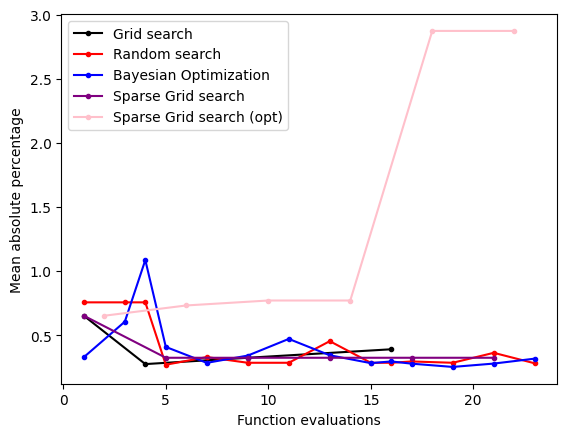

###################### Current dataset 359952 ######################
Target average: tensor([50076.3906])
Min target: tensor([0.]) Max target: tensor([500001.])


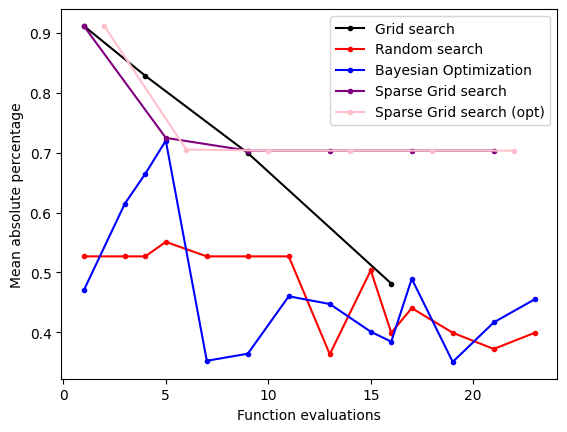

###################### Current dataset 359931 ######################
Target average: tensor([15.0746])
Min target: tensor([12.5000]) Max target: tensor([17.5000])


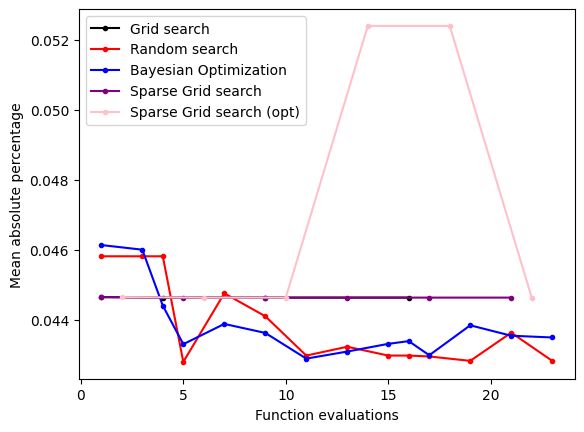

###################### Current dataset 359949 ######################
Target average: tensor([540084.6250])
Min target: tensor([75000.]) Max target: tensor([7700000.])


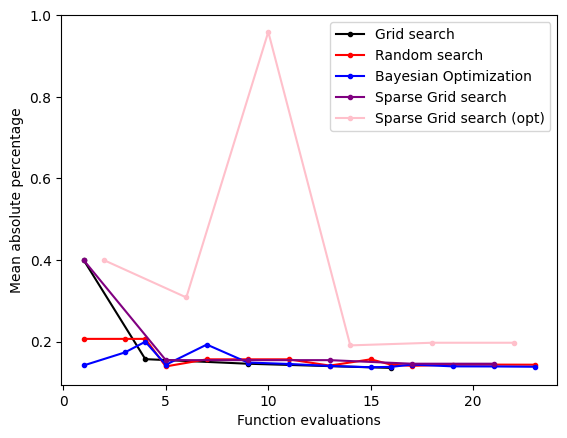

###################### Current dataset 359938 ######################
Target average: tensor([5490.4849])
Min target: tensor([499.]) Max target: tensor([1120000.])


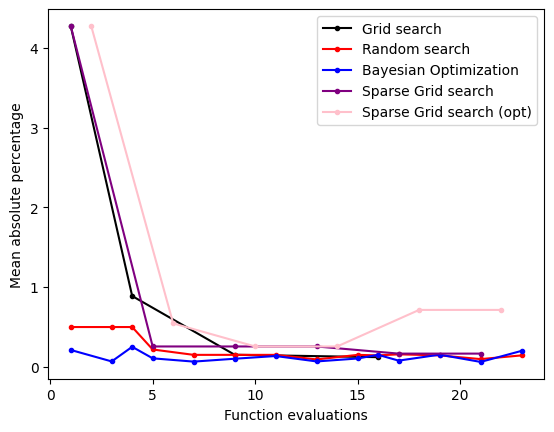

In [35]:
for i in range(len(ids)):
    print("###################### Current dataset", ids[i], "######################")
    
    dataset = HPO.Dataset(task_id=ids[i])
    
    print("Target average:", sum(
        dataset.get_Y()/len(dataset.get_Y())))
    print("Min target:", min(dataset.get_Y()),
          "Max target:", max(dataset.get_Y()))


    # plotting the points 
    plt.plot(GRID_COST[i], GRID_RESULT[i], '.-', color='black', label="Grid search")
    plt.plot(RANDOM_COST[i], RANDOM_RESULT[i], '.-', color='red', label="Random search")
    plt.plot(BAYESIAN_COST[i], BAYESIAN_RESULT[i], '.-', color='blue', label="Bayesian Optimization")
    plt.plot(SPARSE_COST[i], SPARSE_RESULT[i], '.-', color='purple', label="Sparse Grid search")
    plt.plot(SPARSE_COST_OPTIMIZED[i], SPARSE_RESULT_OPTIMIZED[i], '.-', color='pink', label="Sparse Grid search (opt)")
    
    # naming the x axis
    plt.xlabel('Function evaluations')
    # naming the y axis
    plt.ylabel('Mean absolute percentage')
    
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()